In this session we are going to build a GPT like decoder only transformer from scratch. Before we start, let's see what is the architecture of a known-good GPT-2 (124M) from Hugging Face.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# fixed seed for reproduciblity
import os, random, numpy as np, torch

def set_seed(seed=42):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For deterministic CuDNN kernels
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

# Huggingface GPT2

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load model and tokenizer from huggingface
tokenizer_hf = AutoTokenizer.from_pretrained("openai-community/gpt2")
model_hf = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
import torch

# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_hf.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
print("GPT-2 Configuration:")
print(model_hf.config)

GPT-2 Configuration:
GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "dtype": "float32",
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.57.1",
  "use_cache": true,
  "vocab_size": 50257
}



In [ ]:
import time

text = "Children were playing at the"

start = time.time()
encoded_input = tokenizer_hf(text, return_tensors='pt').to(device)
output_ids = model_hf.generate(
    **encoded_input,
    max_new_tokens=15,   # total length = input + new tokens
    num_return_sequences=1,
)
end = time.time()

generated_text = tokenizer_hf.decode(output_ids[0], skip_special_tokens=True)
print("Output text:\n", generated_text)
print("Inference time:", end - start, "s")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output text:
 Children were playing at the time of the attack, but were not injured.

The attack was
Inference time: 0.9566576480865479 s


# Our GPT2

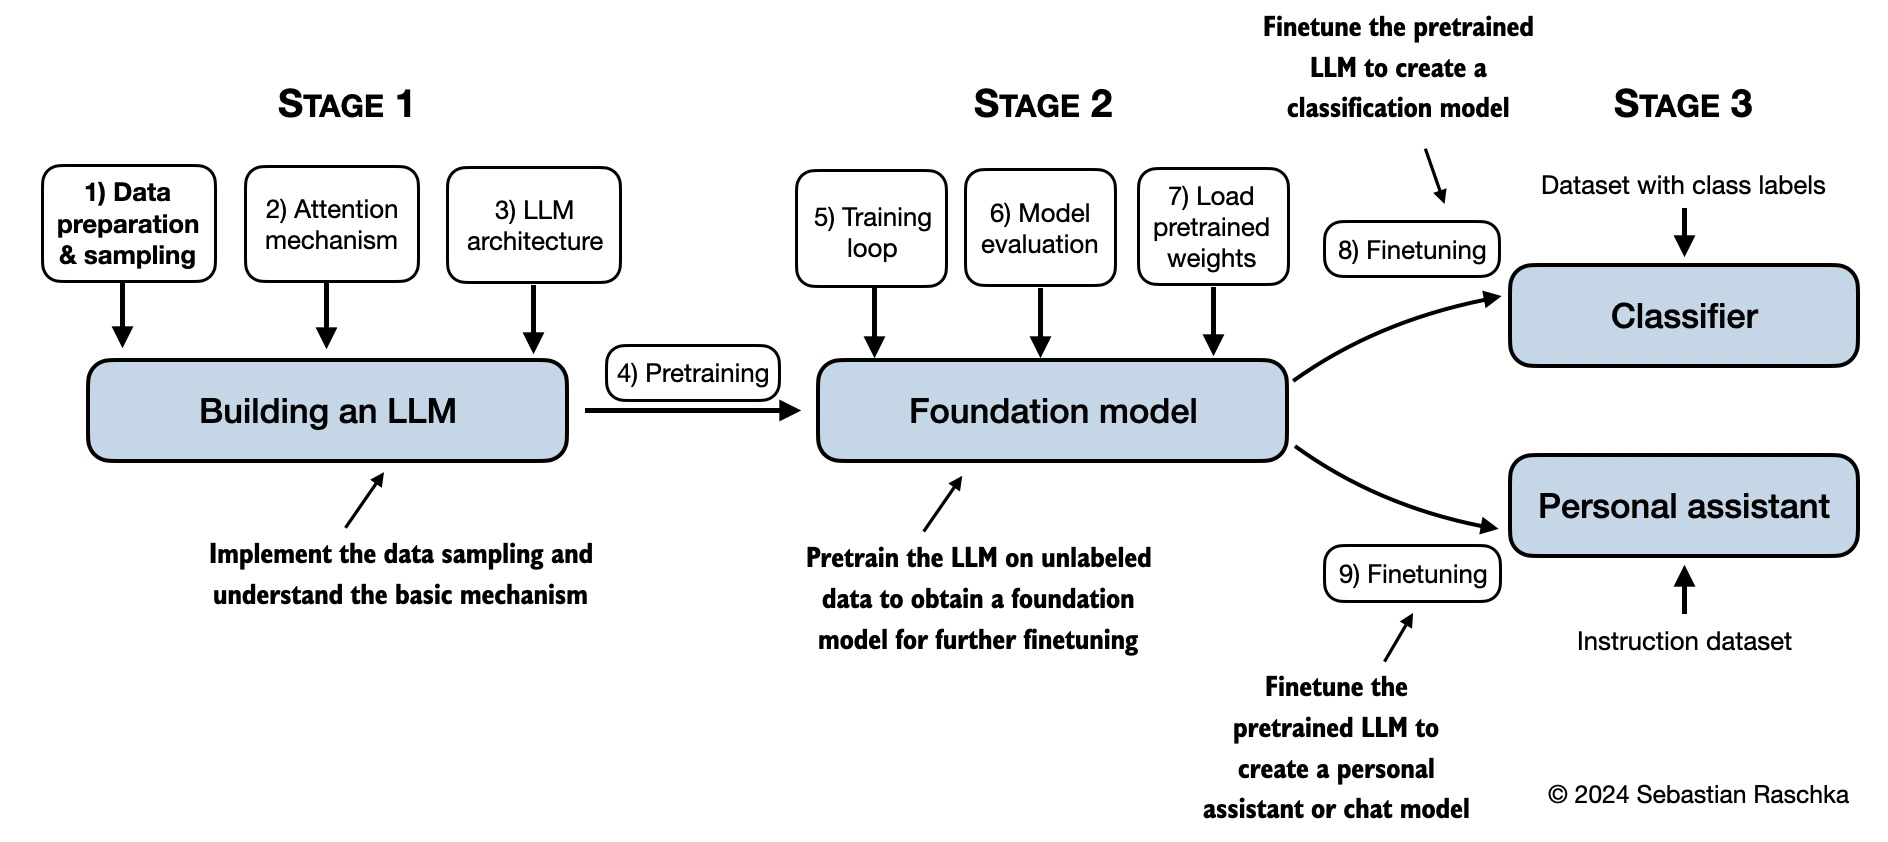

## Stage 1. Building GPT2's Architecture

### 1.1. Dataset Preparation & Sampling


#### 1.1.1. Data Loading

GPT-2 was originally trained on WebText. Since that dataset isn’t publicly
available, we use the educational subset of FineWeb (FineWebEdu-10B), as a high-quality
replacement. Duo to time and memory constraints, we only use 100 samples for model training.


In [ ]:
import os
from datasets import load_dataset

In [ ]:
dataset = load_dataset(
    path="HuggingFaceFW/fineweb-edu",
    name="sample-10BT",
    split="train",
    data_files=["sample/10BT/000_00000.parquet"]
)
print(f"Loaded FineWeb Edu: {dataset}")

# select a subset with 100 samples from the dataset
subset = dataset.select(range(100))
# Join all text samples into one string
raw_text = "".join(subset["text"])

print(f"Number of characters: {len(raw_text):,}")
print("Preview:\n", subset[0]["text"])

README.md: 0.00B [00:00, ?B/s]

sample/10BT/000_00000.parquet:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loaded FineWeb Edu: Dataset({
    features: ['text', 'id', 'dump', 'url', 'file_path', 'language', 'language_score', 'token_count', 'score', 'int_score'],
    num_rows: 726000
})
Number of characters: 369,106
Preview:
 The Independent Jane
For all the love, romance and scandal in Jane Austen’s books, what they are really about is freedom and independence. Independence of thought and the freedom to choose.
Elizabeth’s refusal of Mr. Collins offer of marriage showed an independence seldom seen in heroines of the day. Her refusal of Mr. Darcy while triggered by anger showed a level of independence that left him shocked and stunned.
The freedom she exhibited in finally accepting him in direct defiance of Lady Catherine and knowing her father would disapprove was unusual even for Austen. In her last book Anne Elliot is persuaded to refuse Captain Wentworth at Lady Russel’s insistence.
Although Jane played by the rules of the day, all of her writing is infused with how she wanted life to be.

#### 1.1.2. BPE (Byte Pair Encoding) Tokenizer

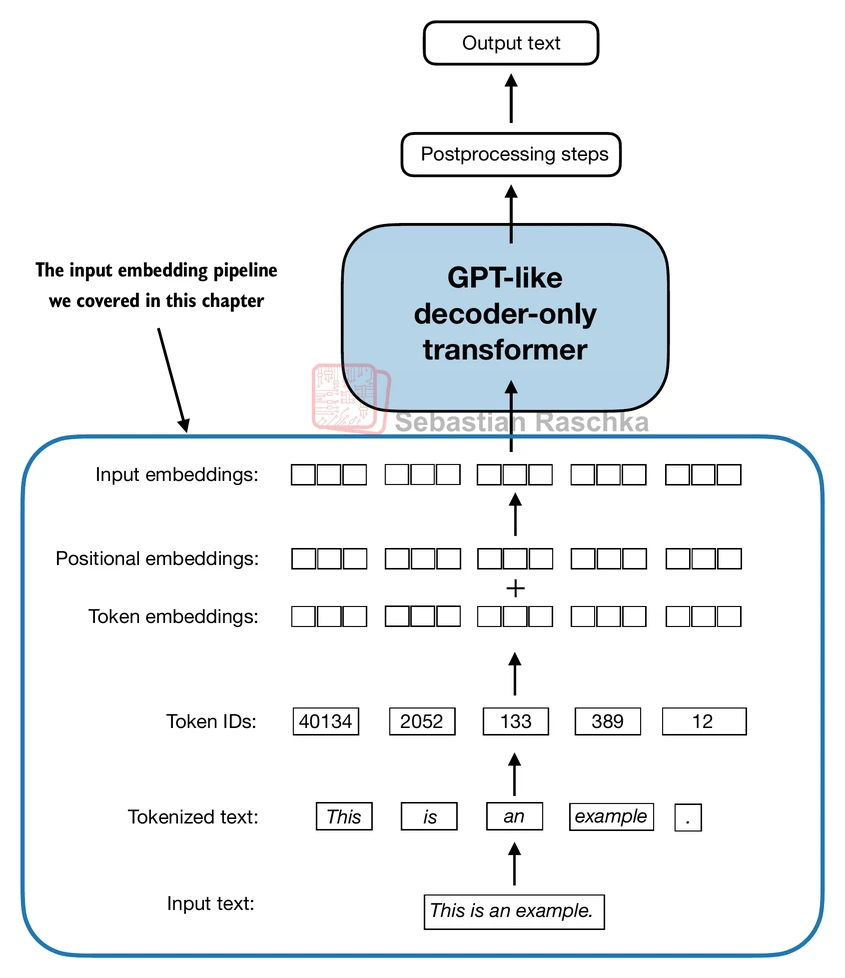

This section implements a Byte Pair Encoding (BPE) tokenizer from scratch.
BPE iteratively merges frequent symbol pairs to form subword units.


BPE Algorithm
--------------------------

1. Initialize the vocabulary : Start with all characters.

'the apple fell down the tree' : 't','h','e','Ġ','a','p','p','l','e','Ġ','f','e','l','l','Ġ',
'd','o','w','n','Ġ','t','h','e','Ġ','t','r','e','e'

2. Count pairs of bytes : Count how often a pair appears

't','h':2
'h','e' : 2
'p','p' : 1

3. Merge the most frequent pair to a new symbol : Say 't','h' is the pair

't','h' → 'th'

4. Update the vocabulary: Replace the occurrence of that pair with the new character

'th','e','Ġ','a','p','p','l','e','Ġ','f','e','l','l','Ġ', 'd','o','w','n','Ġ','th','e','Ġ','t','r','e','e'

5. Repeat till the vocabulary size is reached or no more frequent pairs are available. Save the merge rules and use them for tokenizing any incoming text.

In [ ]:
from collections import Counter, deque
from functools import lru_cache
from tqdm import tqdm
import json
import re
import torch
import torch.nn as nn

In [ ]:
class BPETokenizer:
    """
    Byte-Pair Encoding (BPE) Tokenizer — GPT-2 style
    ------------------------------------------------
    Implements a minimal, fully self-contained version of GPT-2’s tokenizer:
      • Handles 'Ġ' space-prefix convention
      • Learns merges based on pair frequencies
      • Supports <|special|> tokens
      • Performs hierarchical BPE merges per token
yes
    Attributes:
        vocab (dict[int, str]): Maps token_id → token string
        inverse_vocab (dict[str, int]): Maps token string → token_id
        bpe_merges (dict[tuple[int, int], int]): Stores merge rules
    """

    def __init__(self):
        self.vocab = {}
        self.inverse_vocab = {}
        self.bpe_merges = {}

    def train(self, text, vocab_size, allowed_special={"<|endoftext|>"}):
        """
        Train the BPE tokenizer from scratch on a raw text corpus.

        Args:
            text (str): Training text.
            vocab_size (int): Desired vocabulary size (GPT-2 ≈ 50 k).
            allowed_special (set[str]): Special tokens to include (e.g. <|endoftext|>).
        """

        # 1. Preprocess: replace spaces with 'Ġ' (GPT-2 convention)
        processed_text = text.replace(" ", "Ġ")

        # 2. Initialize vocab with ASCII + observed chars + Ġ
        unique_chars = [chr(i) for i in range(256)]
        unique_chars.extend(
            ch for ch in sorted(set(processed_text)) if ch not in unique_chars
        )
        if "Ġ" not in unique_chars:
            unique_chars.append("Ġ")

        self.vocab = {i: ch for i, ch in enumerate(unique_chars)}
        self.inverse_vocab = {ch: i for i, ch in self.vocab.items()}

        # 3. Add allowed special tokens (e.g. <|endoftext|>)
        for tok in allowed_special or []:
            if tok not in self.inverse_vocab:
                new_id = len(self.vocab)
                self.vocab[new_id] = tok
                self.inverse_vocab[tok] = new_id

        # 4. Convert processed text → token IDs
        token_ids = [self.inverse_vocab[ch] for ch in processed_text]

        # 5. Repeatedly merge the most frequent pairs until reaching vocab_size
        for new_id in tqdm(range(len(self.vocab), vocab_size), desc="Training BPE"):
          # Find the most common consecutive pair
            pair_id = self.find_freq_pair(token_ids, mode="most")
            if pair_id is None:
                break
            # Replace all instances of that pair with a new merged token ID
            token_ids = self.replace_pair(token_ids, pair_id, new_id)
            # Save this merge mapping
            self.bpe_merges[pair_id] = new_id

        # 6. Add merged tokens to vocab
        for (p0, p1), new_id in self.bpe_merges.items():
            merged_token = self.vocab[p0] + self.vocab[p1]
            self.vocab[new_id] = merged_token
            self.inverse_vocab[merged_token] = new_id

    def encode(self, text, allowed_special=None):
        """
        Encode text → list of token IDs.

        Args:
            text (str): Input text.
            allowed_special (set[str] | None): Special tokens to allow passthrough.

        Returns:
            list[int]: Encoded token IDs.
        """
        token_ids = []

        # --- Handle special tokens first
        if allowed_special:
          # Build a regex pattern for allowed special tokens
            special_pattern = (
                "("
                + "|".join(
                    re.escape(tok)
                    for tok in sorted(allowed_special, key=len, reverse=True)
                )
                + ")"
            )
            last_idx = 0
            for m in re.finditer(special_pattern, text):
                # Encode text before the special token (no special handling)
                prefix = text[last_idx:m.start()]
                token_ids.extend(self.encode(prefix, allowed_special=None))

                # Add the special token itself
                special = m.group(0)
                if special not in self.inverse_vocab:
                    raise ValueError(f"Unknown special token: {special}")
                token_ids.append(self.inverse_vocab[special])
                last_idx = m.end()

            # Remaining text after last special token
            text = text[last_idx:]

            # Check for any disallowed <|...|> tokens
            disallowed = [
                tok for tok in self.inverse_vocab
                if tok.startswith("<|") and tok.endswith("|>")
                and tok in text and tok not in allowed_special
            ]
            if disallowed:
                raise ValueError(f"Disallowed special tokens: {disallowed}")

        # --- Regular text tokenization (split by spaces/newlines)
        tokens = []
        for i, line in enumerate(text.split("\n")):
            if i > 0:
                tokens.append("\n") # preserve newlines
            words = line.split()
            for j, word in enumerate(words):
                # First word of first line = plain word
                # All others get prefixed with 'Ġ' to mark a space
                prefix = "Ġ" if j > 0 or i > 0 else ""
                tokens.append(prefix + word)

        # --- Convert each piece to IDs via vocab or BPE merges
        for tok in tokens:
            if tok in self.inverse_vocab:
                token_ids.append(self.inverse_vocab[tok])
            else:
                # Apply BPE rules for unseen tokens
                token_ids.extend(self.tokenize_with_bpe(tok))
        return token_ids

    def tokenize_with_bpe(self, token):
        """
        Apply learned BPE merges to a single token string.

        Args:
            token (str): Input subword candidate.

        Returns:
            list[int]: Final token IDs for that subword.
        """
        # Start with character-level tokens
        token_ids = [self.inverse_vocab.get(ch) for ch in token]

        # Ensure all characters exist in vocab
        if None in token_ids:
            missing = [ch for ch, tid in zip(token, token_ids) if tid is None]
            raise ValueError(f"Characters not found in vocab: {missing}")

        # Iteratively merge until no more pairs exist in merge rules
        can_merge = True
        while can_merge and len(token_ids) > 1:
            can_merge = False
            new_seq = []
            i = 0
            while i < len(token_ids) - 1:
                pair = (token_ids[i], token_ids[i + 1])
                if pair in self.bpe_merges:
                    new_seq.append(self.bpe_merges[pair])
                    i += 2
                    can_merge = True
                else:
                    new_seq.append(token_ids[i])
                    i += 1
            # Append last leftover token if any
            if i < len(token_ids):
                new_seq.append(token_ids[i])
            token_ids = new_seq
        return token_ids

    def decode(self, token_ids):
        """
        Decode list of token IDs → text string.

        Args:
            token_ids (list[int]): Token sequence.

        Returns:
            str: Decoded text.
        """
        decoded = ""
        for tid in token_ids:
            if tid not in self.vocab:
                raise ValueError(f"Unknown token ID: {tid}")
            tok = self.vocab[tid]
            # Preserve newlines properly with spacing
            if tok == "\n":
                if decoded and not decoded.endswith(" "):
                    decoded += " "
                decoded += tok
            # Tokens starting with 'Ġ' represent a space before them
            elif tok.startswith("Ġ"):
                decoded += " " + tok[1:]
            else:
                decoded += tok
        return decoded

    def save_vocab_and_merges(self, vocab_path, merges_path):
        """Save vocab and merge rules as JSON files."""
        with open(vocab_path, "w", encoding="utf-8") as f:
            json.dump(self.vocab, f, ensure_ascii=False, indent=2)
        merges_list = [
            {"pair": list(pair), "new_id": new_id}
            for pair, new_id in self.bpe_merges.items()
        ]
        with open(merges_path, "w", encoding="utf-8") as f:
            json.dump(merges_list, f, ensure_ascii=False, indent=2)

    def load_vocab_and_merges(self, vocab_path, merges_path):
        """Load vocab and merge rules from disk."""
        with open(vocab_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        self.vocab = {int(k): v for k, v in data.items()}
        self.inverse_vocab = {v: int(k) for k, v in data.items()}

        with open(merges_path, "r", encoding="utf-8") as f:
            merges = json.load(f)
        for m in merges:
            pair = tuple(m["pair"])
            self.bpe_merges[pair] = m["new_id"]

    @lru_cache(maxsize=None)
    def get_special_token_id(self, token):
        """Return ID of a special token, or None."""
        return self.inverse_vocab.get(token)

    @staticmethod
    def find_freq_pair(token_ids, mode="most"):
        """Find the most/least frequent adjacent token pair."""
        pairs = Counter(zip(token_ids, token_ids[1:]))
        if not pairs:
            return None
        if mode == "most":
            return max(pairs.items(), key=lambda x: x[1])[0]
        elif mode == "least":
            return min(pairs.items(), key=lambda x: x[1])[0]
        raise ValueError("mode must be 'most' or 'least'")

    @staticmethod
    def replace_pair(token_ids, pair_id, new_id):
        """Replace all occurrences of a pair with a merged token."""
        dq, replaced = deque(token_ids), []
        while dq:
            cur = dq.popleft()
            # Merge pair if next two match the target pair
            if dq and (cur, dq[0]) == pair_id:
                replaced.append(new_id)
                dq.popleft()  # skip second of the pair
            else:
                replaced.append(cur)
        return replaced

In [ ]:
tokenizer = BPETokenizer()
tokenizer.train(raw_text, vocab_size=50257, allowed_special="<|endoftext|>")

Training BPE:   0%|          | 5/49972 [00:00<1:18:51, 10.56it/s]


KeyboardInterrupt: 

In [ ]:
tokenizer = BPETokenizer()
tokenizer.load_vocab_and_merges(
    vocab_path="bpe_vocab.json", merges_path="bpe_merges.json"
)
print("Vocabulary size:", len(tokenizer.vocab))

Vocabulary size: 50257


In [ ]:
text = "Let's build an LLM!"
encoded_text = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print("Encoded text:", encoded_text)

for token_id in encoded_text:
    print(f"{token_id} -> {tokenizer.decode([token_id])}")

Encoded text: [4119, 116, 4566, 265, 1894, 100, 265, 404, 5129, 17654, 33]
4119 -> Le
116 -> t
4566 -> 's
265 ->  
1894 -> buil
100 -> d
265 ->  
404 -> an
5129 ->  L
17654 -> LM
33 -> !


#### 1.1.3. Positional Encodings

Positional encodings allow the model to use the order of tokens in a sequence — something lost in plain embeddings. As introduced in the class, we have **absolute** and **relative** positional encoding. There are 2 types of Absolute positional encoding:
1. **Sinusoidal positional encoding**: A non-learned, fixed method that uses predefined sine and cosine functions. It is beneficial because it doesn't add parameters; however, generalizing to longer sequences may not be interpretable to the model.
2. **Learned positional encoding**: A learned, trainable version where the model learns a specific vector for each position. This requires additional parameters but can be more flexible than sinusoidal methods. GPT-2 uses **learned absolute** position embeddings:
  position_emb[pos] ∈ ℝ^d
These are added element-wise to token embeddings.


In this section, we will implement the Learned positional encodings and will leave the implementation of Sinusoidal positional encoding to the mini-project.

In [ ]:
import torch
import torch.nn as nn
import math

##### 1.1.3.1. Absolute Learned Positional Encodings

In [ ]:
class LearnedPositionalEmbedding(nn.Module):
    """
    Implements learnable positional embeddings as used in GPT models.
    Adds a trainable vector for each position in the input sequence.
    """

    def __init__(self, context_length: int, embedding_dim: int):
        """
        Args:
            context_length (int): Maximum sequence length (context size).
            embedding_dim (int): Dimensionality of token embeddings.
        """
        super().__init__()
        # One trainable vector per position
        self.pos_embedding = nn.Embedding(context_length, embedding_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Adds learned positional embeddings to token embeddings.
        Args:
            x: Tensor of shape [batch_size, seq_len, embedding_dim]
        Returns:
            Tensor of same shape, with positional encodings added.
        """
        print(x.shape)
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device) # [0,1,2,…,seq_len-1]
        pos_emb = self.pos_embedding(positions) # [batch_size, seq_len, d_model]
        return x + pos_emb

In [ ]:
batch_size, seq_len, emb_dim = 2, 8, 24

# Simulated token embeddings
token_embeddings = torch.randn(batch_size, seq_len, emb_dim)

# Use learned positional encoding (GPT style)
learned_pe = LearnedPositionalEmbedding(context_length=seq_len, embedding_dim=emb_dim)
encoded = learned_pe(token_embeddings)

print("Input shape:", token_embeddings.shape) # batch_size x seq_len x emb_dim
print("After learned positional encoding:", encoded.shape) # batch_size x seq_len x emb_dim

torch.Size([2, 8, 24])
Input shape: torch.Size([2, 8, 24])
After learned positional encoding: torch.Size([2, 8, 24])


##### 1.1.3.2. Absolute Sinusoidal Positional Encodings

##### 1.1.3.3. Relative Rotary Positional Encodings (Optional)

In [ ]:
class SinusoidalPositionalEncoding(nn.Module):
    """
    TODO: Implement sine/cosine positional embeddings
    """
    def __init__(self, embedding_dim: int, max_length: int):
        super().__init__()
        # TODO: Create the sinusoidal encoding matrix here

        if(embedding_dim %2 !=0):  #for sinusoidal embedding, the embedding dimesnion must be even, as sin and cos alternate.
          raise ValueError("Embedding dimension need to be even")

        self.embedding_dim = embedding_dim
        self.num_embeddings = max_length

        # Creating positional_embedding matrix and initializing with zeros.
        positional_embedding = torch.zeros(max_length,embedding_dim)
        positions = torch.arange(0,max_length,dtype=torch.float).unsqueeze(1) #Using unsqueeze to match the dimension of the positional_embedding

        division_term = torch.pow(10000, 2*torch.arange(0,embedding_dim//2,dtype=torch.float)/embedding_dim)

        positional_embedding[:,0::2] = torch.sin(positions/division_term)
        positional_embedding[:,1::2] = torch.cos(positions/division_term)

        self.pos_emb = positional_embedding

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Add positional encodings to token embeddings
        seq_len = x.size(1)

        pos_emb = self.pos_emb[:seq_len,:].to(x.device) #Trim it to seq_length

        return x + pos_emb.unsqueeze(0)

In [ ]:
batch_size, seq_len, emb_dim = 2, 8, 24

# Simulated token embeddings
token_embeddings = torch.randn(batch_size, seq_len, emb_dim)

print("Input shape:", token_embeddings.shape)   # [batch_size, seq_len, emb_dim]

#Test Call to check if the output dimension is correct.
sino_emb = SinusoidalPositionalEncoding(emb_dim,seq_len)
encoded = sino_emb(token_embeddings)
print("After sinusoidal positional encoding:", encoded.shape) # [batch_size, seq_len, emb_dim]

Input shape: torch.Size([2, 8, 24])
After sinusoidal positional encoding: torch.Size([2, 8, 24])


In [ ]:
class RotaryPositionalEncoding(nn.Module):
    """
    TODO: Implement rotary positional embeddings
    """
    def __init__(self, embedding_dim: int, max_length: int):
        super().__init__()
        # TODO
        pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Apply positional encodings to token embeddings
        return x

#### 1.1.4. Dataset and DataLoader

This stage builds a PyTorch `Dataset` and `DataLoader` to feed tokenized text
into the GPT-2 model for next-token prediction (causal language modeling).

Each training example:

    x = tokens[i : i + block_size]
    y = tokens[i+1 : i + block_size + 1]
    
That is, the model learns to predict the next token in a sequence.



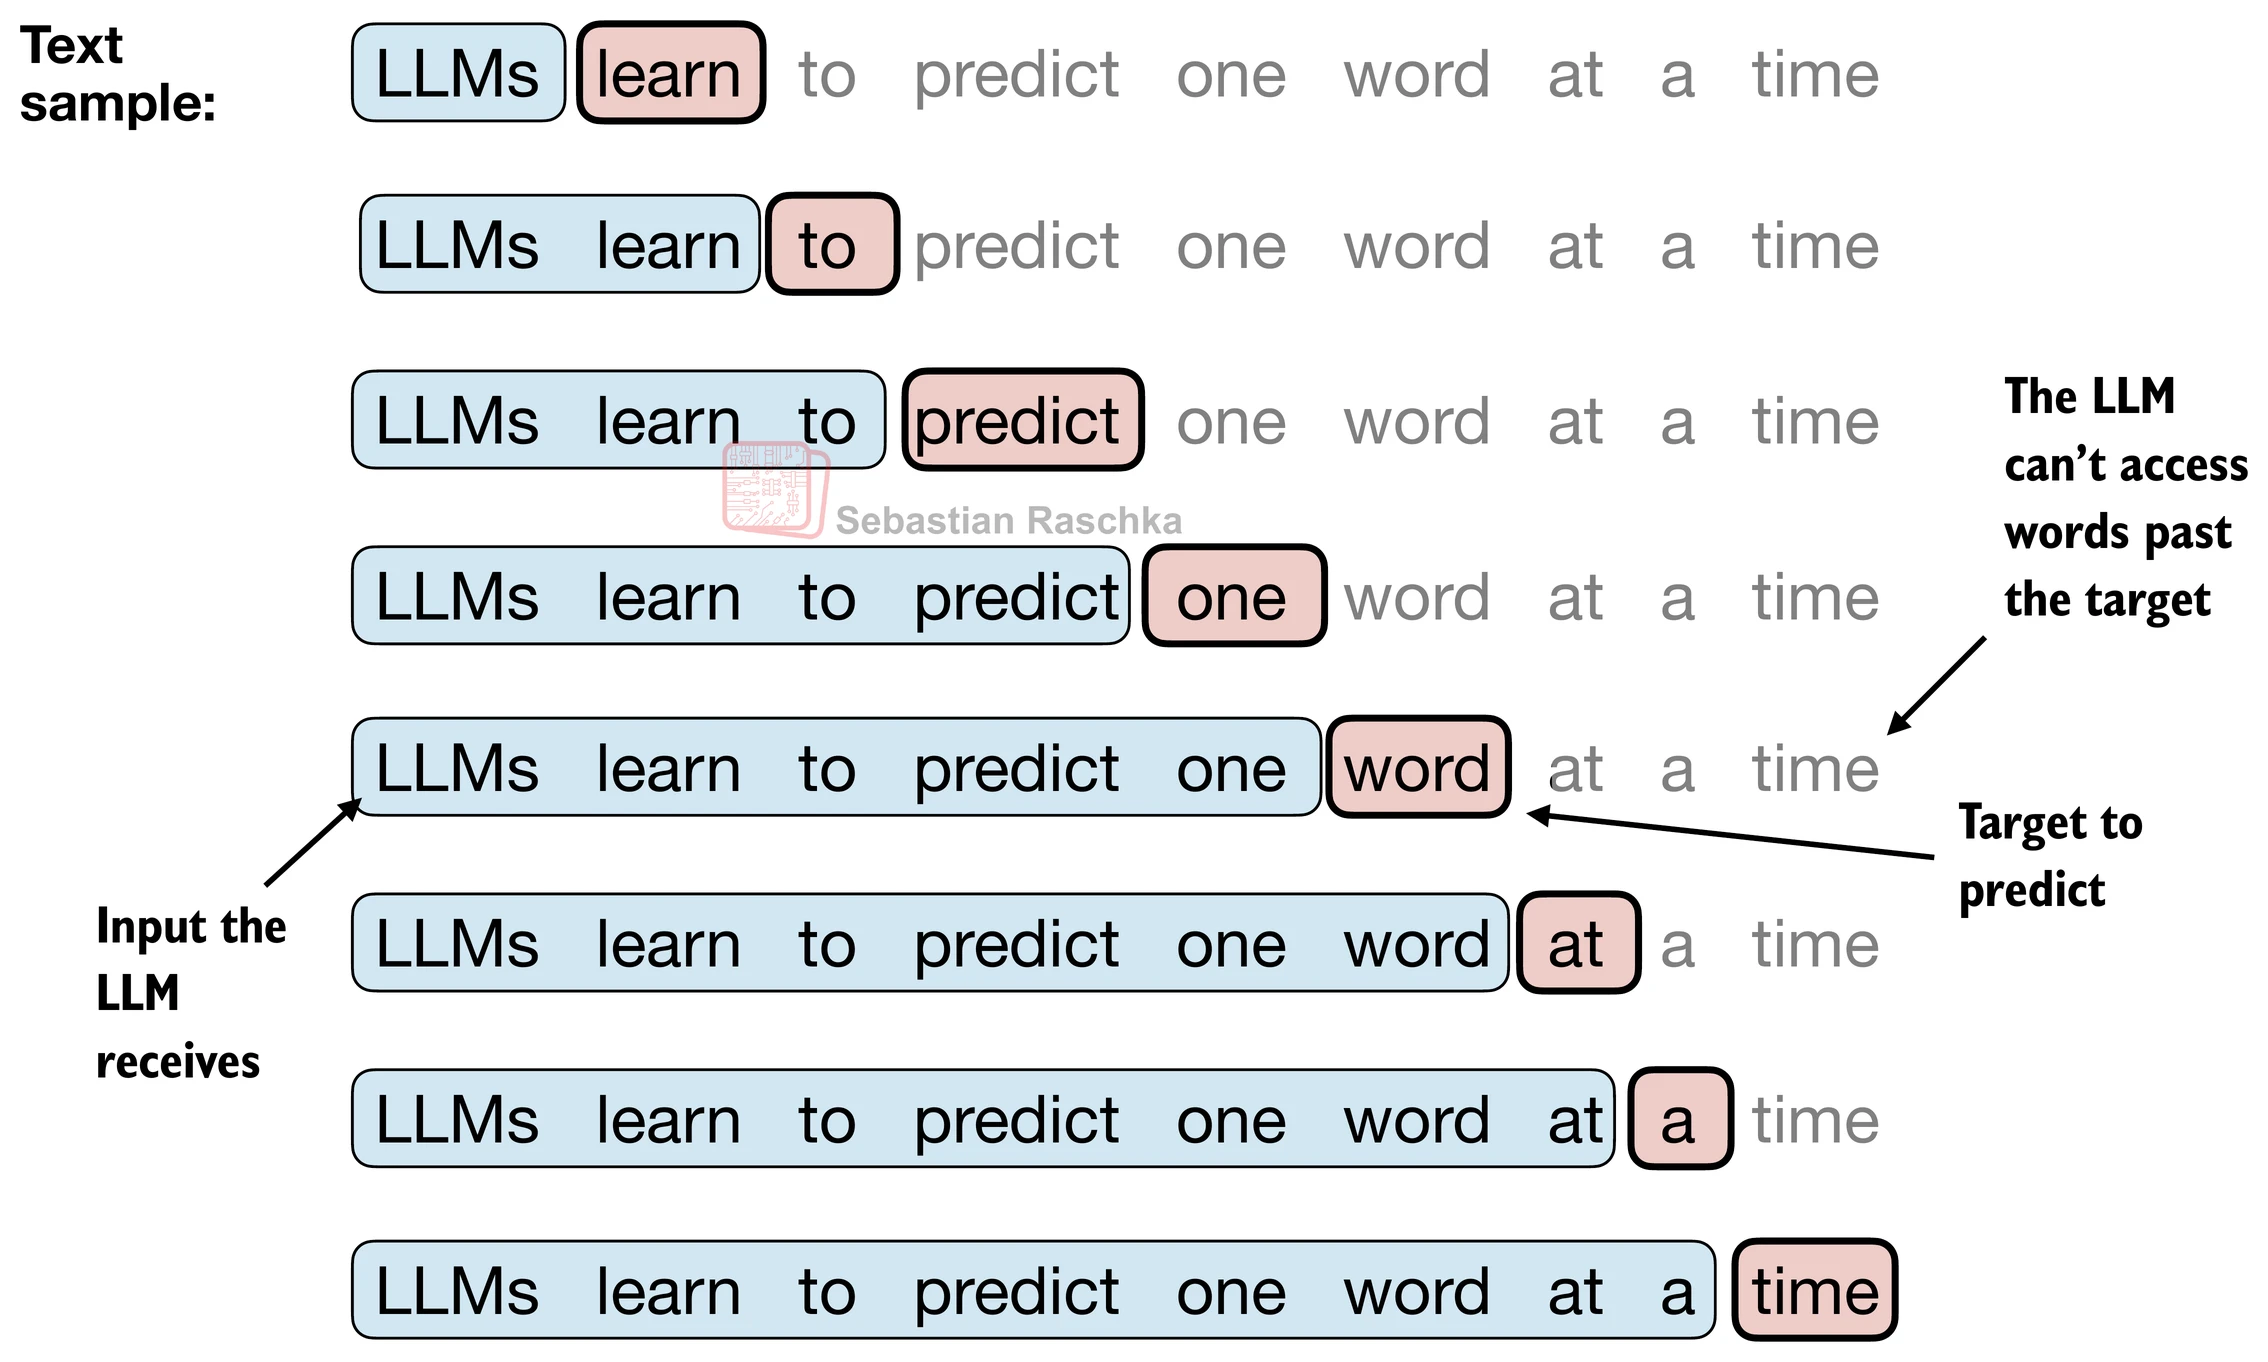

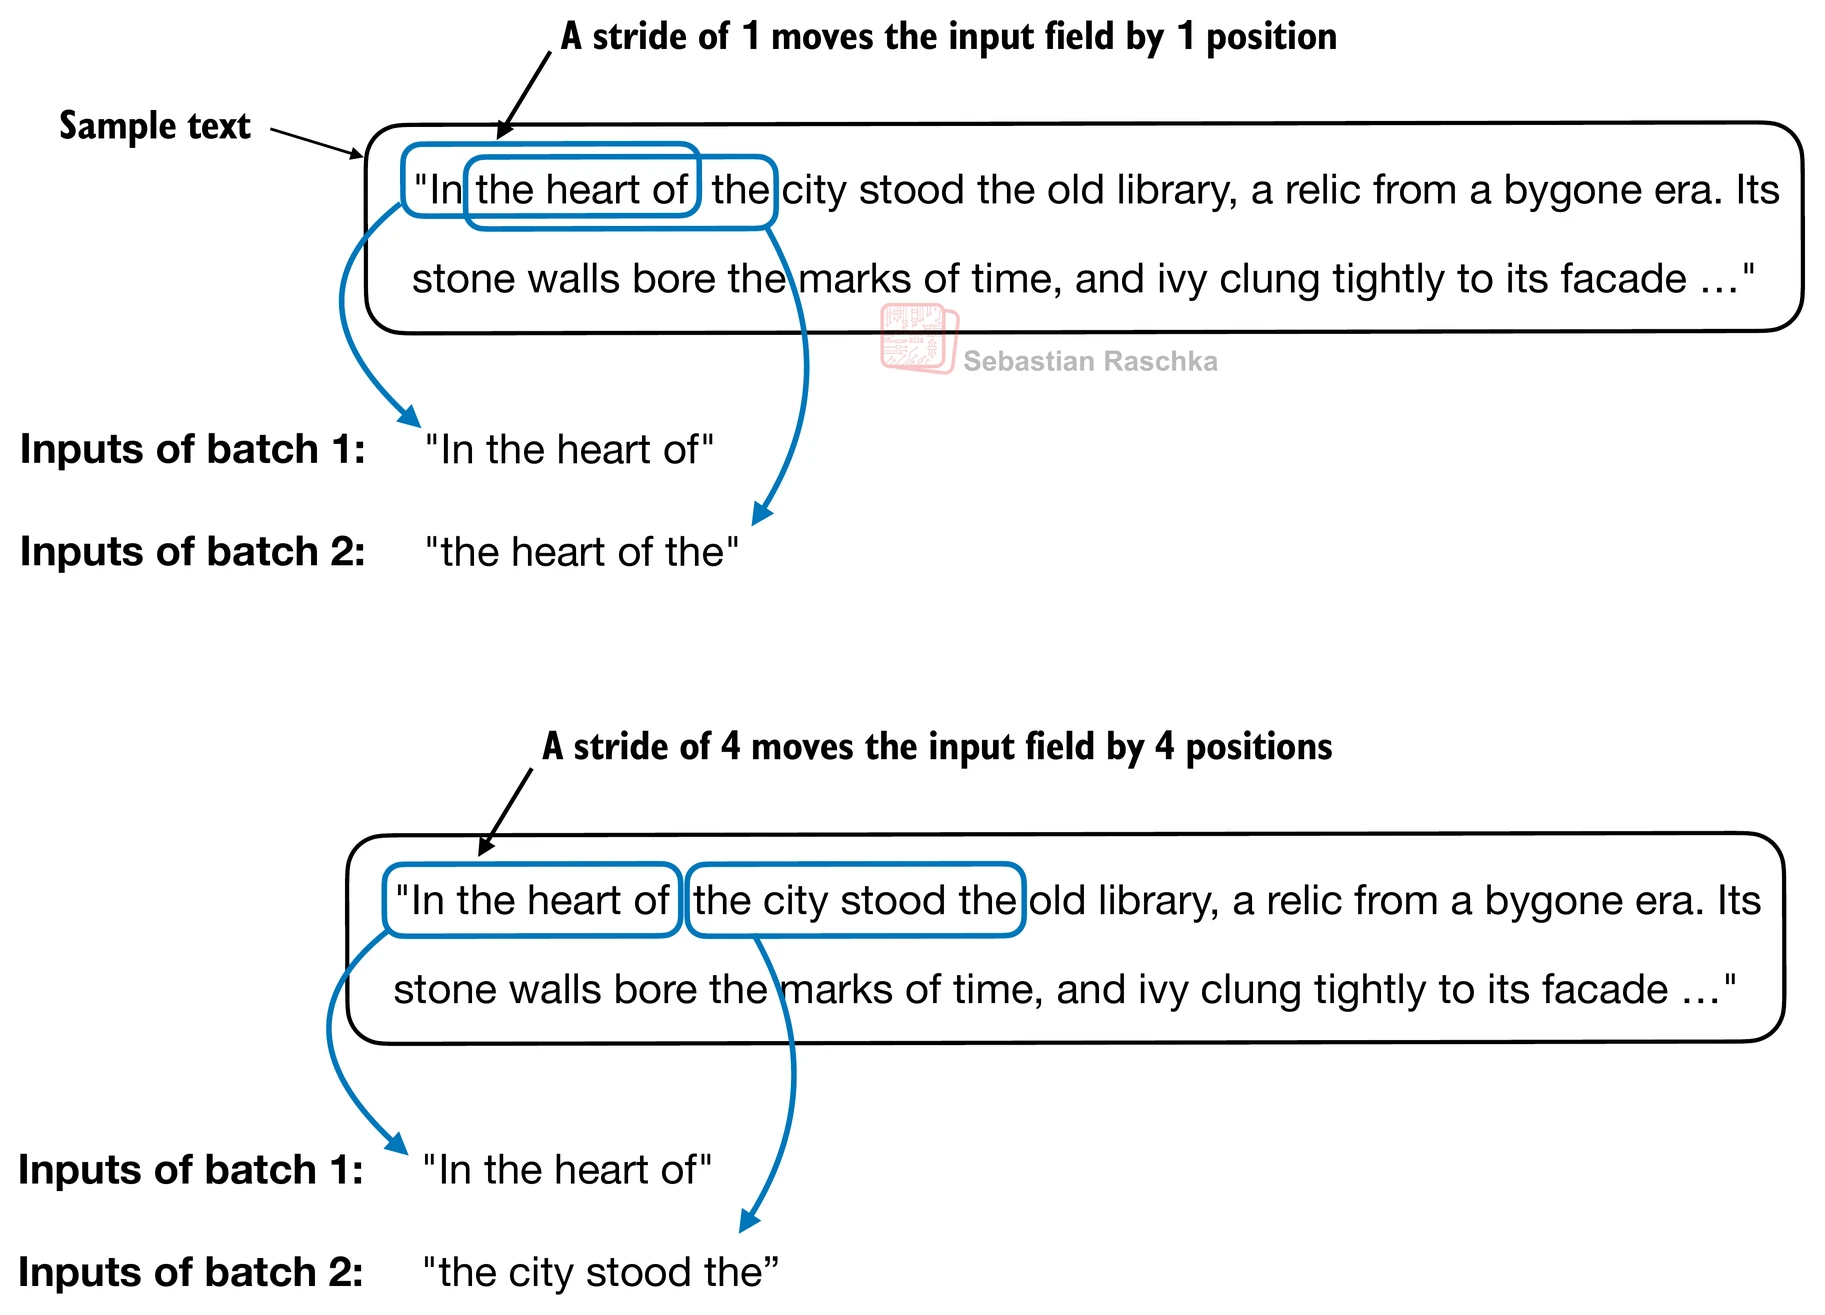

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List
from tqdm import tqdm

In [ ]:
class TextDataset(Dataset):
    """
    Converts a long text string into overlapping examples for next-token prediction.
    Each sample is a tuple (input_ids, target_ids), both of length `block_size`.

    Example:
        Text: "The cat sat on the mat and ate fish !"
        Token IDs: [10, 20, 30, 40, 50, 60, 70, 80, 90]
        context_window/block_size = 4, stride = 4  → samples:
            x = [10, 20, 30, 40], y = [20, 30, 40, 50]
            x = [50, 60, 70, 80], y = [60, 70, 80, 90]
    """

    def __init__(self, text: str, tokenizer, block_size: int, stride: int):
        """
        Args:
            text (str): Full raw text string.
            tokenizer (BPETokenizer): Trained BPE tokenizer instance.
            block_size (int): Number of tokens per sequence.
            stride (int): Step size between sequences (controls overlap).
        """
        self.block_size = block_size
        self.stride = stride

        # Encode full text into token IDs
        self.token_ids = tokenizer.encode(text)
        self.input_ids, self.target_ids = [], []

        # Use sliding window to create overlapping training examples
        for i in tqdm(
            range(0, len(self.token_ids) - block_size, stride),
            desc="Building dataset"
        ):
            input_chunk = self.token_ids[i:i + block_size]
            target_chunk = self.token_ids[i + 1:i + block_size + 1]
            self.input_ids.append(torch.tensor(input_chunk, dtype=torch.long))
            self.target_ids.append(torch.tensor(target_chunk, dtype=torch.long))

    def __len__(self) -> int:
        """Return total number of (input, target) pairs."""
        return len(self.input_ids)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """Return one sample (x, y) pair."""
        return self.input_ids[idx], self.target_ids[idx]


In [ ]:
dataset = TextDataset(raw_text, tokenizer, block_size=8, stride=4)
print(f"\nDataset Length: {len(dataset)}")

dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
)

Building dataset: 100%|██████████| 47837/47837 [00:00<00:00, 58071.34it/s]


Dataset Length: 47837


In [ ]:
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs shape:", inputs.shape)
print("Outputs shape:", targets.shape)

print("\nSome input output samples:")
for i, (x, y) in enumerate(zip(inputs, targets)):
    print(f"Sample {i}")
    print(f"Input: {tokenizer.decode(x.numpy())}, {x.numpy()}")
    print(f"Output: {tokenizer.decode(y.numpy())}, {y.numpy()}")
    print()

Inputs shape: torch.Size([4, 8])
Outputs shape: torch.Size([4, 8])

Some input output samples:
Sample 0
Input: The Independen, [7546  265  691  768  677  110  768  110]
Output:  Independent, [265 691 768 677 110 768 110 116]

Sample 1
Input: pendent Jane, [ 677  110  768  110  116  265 2313  101]
Output: ndent Jane 
, [ 110  768  110  116  265 2313  101   10]

Sample 2
Input: t Jane 
 For , [ 116  265 2313  101   10 7802  410  265]
Output:  Jane 
 For all, [ 265 2313  101   10 7802  410  265  472]

Sample 3
Input: 
 For all the lo, [  10 7802  410  265  472  525  265 1412]
Output:  For all the love, [7802  410  265  472  525  265 1412 9780]



### 1.2. Attention Mechanism

#### 1.2.1. Multi-Head Attention (MHA)

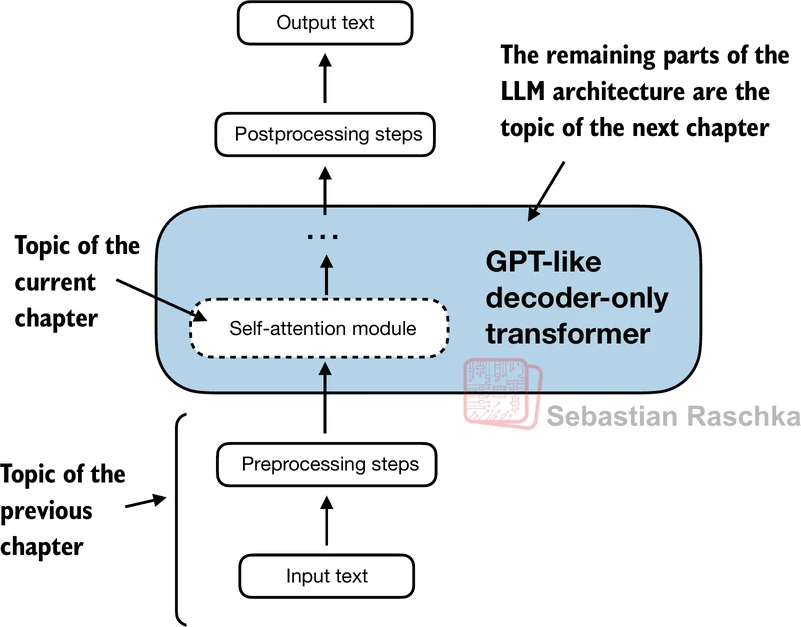

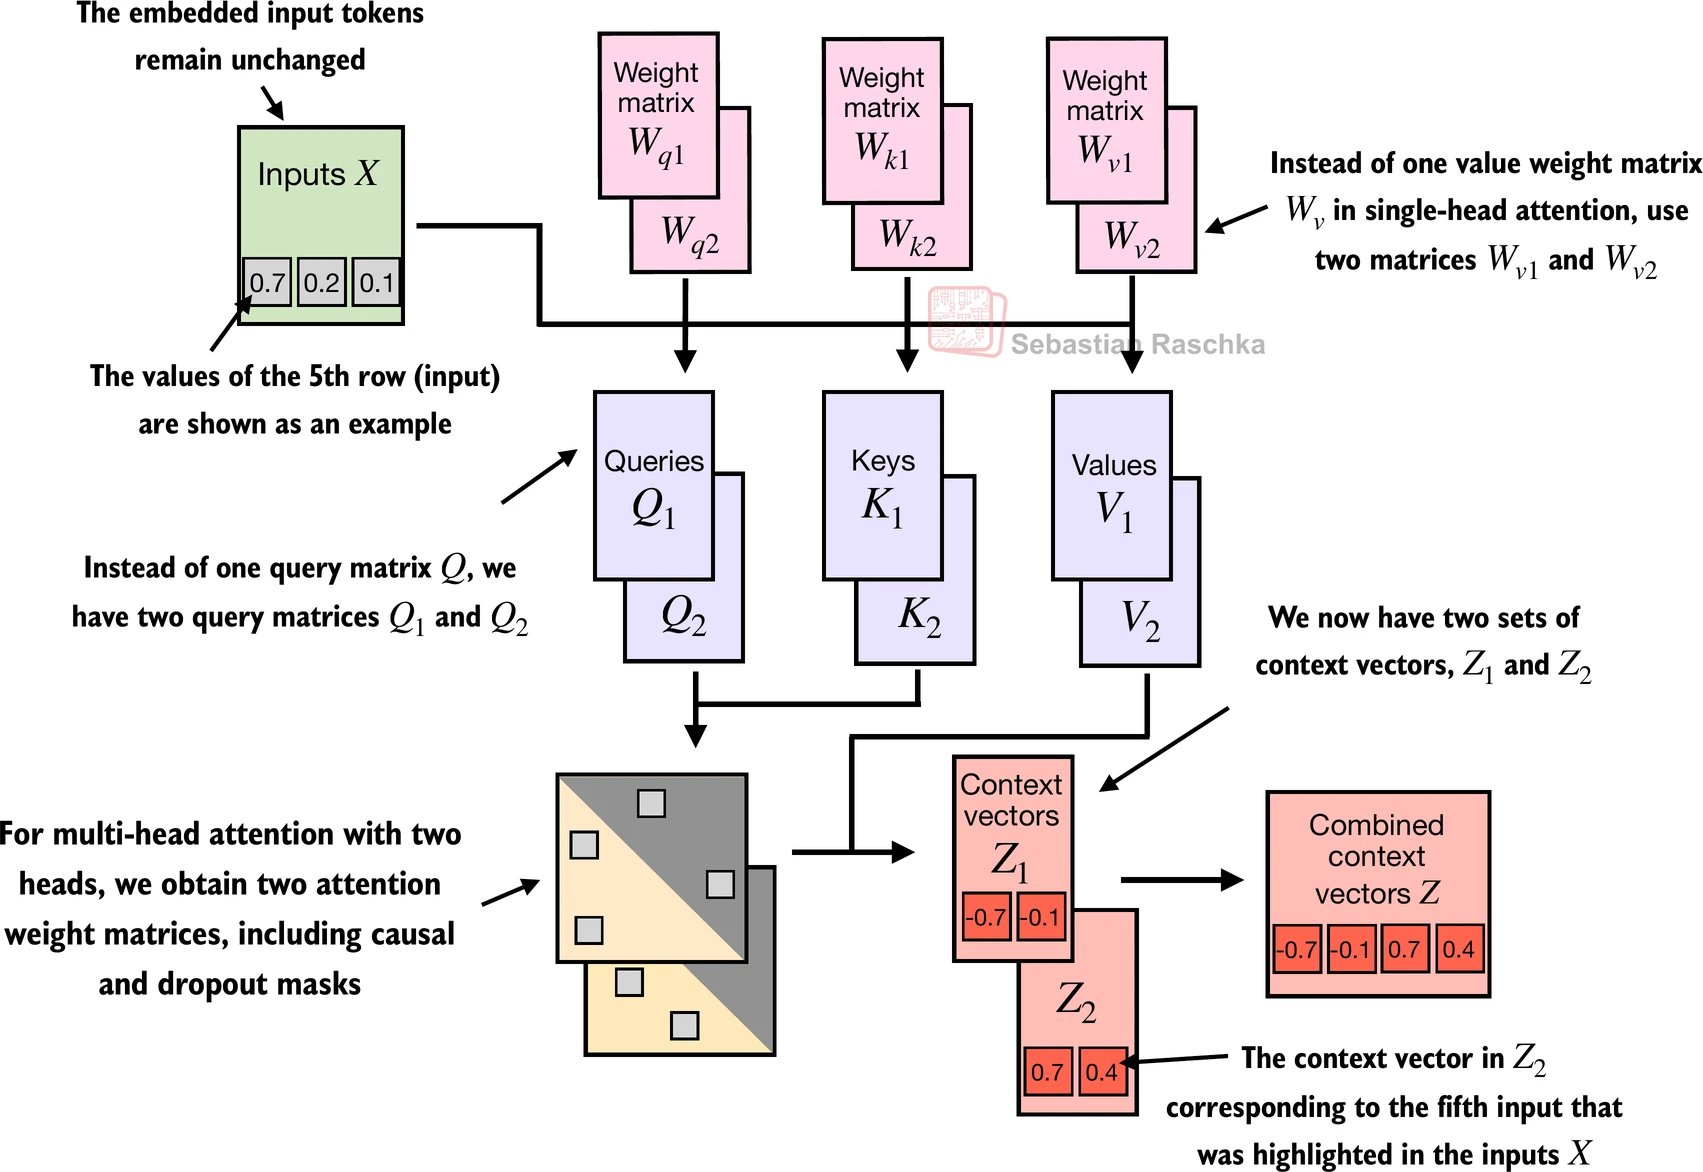

This section implements the multi-head self-attention mechanism,
a fundamental component of transformer-based language models.

Each head projects token embeddings into queries, keys, and values,
computes scaled dot-product attention, and combines results.
Causal masking ensures each token only attends to past tokens, so the model can learn long-range dependencies.

We have left the implementation of Grouped Query Attention (GQA) for your mini-project.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Self-Attention (GPT-2 style)
    --------------------------------------
    Each token embedding x_i produces queries (Q), keys (K), and values (V)
    via separate linear projections:

        Q = x W_Q
        K = x W_K
        V = x W_V

    Then:
        Attention(Q,K,V) = softmax( (Q Kᵀ) / √dₖ + mask ) · V
    """

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        context_length: int,
        dropout: float = 0.1,
        qkv_bias: bool = False,
    ):
        """
        Args:
            embed_dim (int): Token embedding dimension (e.g. 768)
            num_heads (int): Number of attention heads (e.g. 12)
            context_length (int): Maximum sequence length
            dropout (float): Dropout rate
            qkv_bias (bool): Whether to include bias terms in Q/K/V projections
        """
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5  # normalization factor for stability

        # Separate linear projections for Q, K, V
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)

        # Output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        # Dropouts
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

        # Causal Mask
        # Lower-triangular matrix ensures each token can attend only to itself and past tokens.
        mask = torch.tril(torch.ones(context_length, context_length))
        # store this mask tensor as part of the model’s state, but don’t treat it as a learnable parameter
        self.register_buffer("causal_mask", mask.view(1, 1, context_length, context_length)) # (batch, head, query, key)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of multi-head self-attention.

        Args:
            x: [batch, seq_len, embed_dim]

        Returns:
            out: [batch, seq_len, embed_dim]
        """
        B, T, C = x.shape
        H, D = self.num_heads, self.head_dim  #H x D = C

        # 1. Project input to queries, keys, and values
        q = self.q_proj(x).view(B, T, H, D) # (B, T, H, D) --> Batch size , Number of tokens , Number of heads , Model dimension across each head
        k = self.k_proj(x).view(B, T, H, D) # (B, T, H, D)
        v = self.v_proj(x).view(B, T, H, D) # (B, T, H, D)

        # Permute to put heads first: [B, H, T, D]
        q = q.transpose(1, 2) # (B, H, T, D) # For this batch, for this head, for this token, this is the dimensionality
        k = k.transpose(1, 2) # (B, H, T, D)
        v = v.transpose(1, 2) # (B, H, T, D)

        # 2. Compute scaled dot-product attention (QK^T)
        # Attention scores shape: [B, H, T, T]
        attn_scores = (q @ k.transpose(2, 3)) * self.scale # (B, H, T, D) @ (B, H, D, T) -> (B, H, T, T)

        # 3. Apply causal mask (prevent attending to future positions)
        causal_mask = self.causal_mask[:, :, :T, :T] # limiting to number fo tokens rather than context length
        attn_scores = attn_scores.masked_fill(causal_mask == 0, float("-inf"))

        # 4. Softmax normalization and dropout
        attn_probs = F.softmax(attn_scores, dim=-1) # (B, H, T, T)
        attn_probs = self.attn_dropout(attn_probs) # (B, H, T, T)

        # 5. Weighted sum of values
        y = (attn_probs @ v).transpose(1, 2)  # (B, H, T, T) @ (B, H, T, D) -> (B, H, T, D) -transpose-> (B, T, H, D)

        # 6. Merge heads and apply output projection
        y = y.contiguous().view(B, T, C) # (B, T, C)
        y = self.resid_dropout(self.out_proj(y)) # (B, T, C)
        return y


In [ ]:
batch_size = 4
context_length = 8
dim = 24
num_heads = 12

# Simulated token embeddings
token_embeddings = torch.randn(batch_size, context_length, dim)

mha = MultiHeadAttention(embed_dim=dim, num_heads=num_heads, context_length=context_length)
out = mha(token_embeddings)

print("Context vectors shape:", out.shape)

Context vectors shape: torch.Size([4, 8, 24])


#### 1.2.2. Grouped Query Attention (GQA)

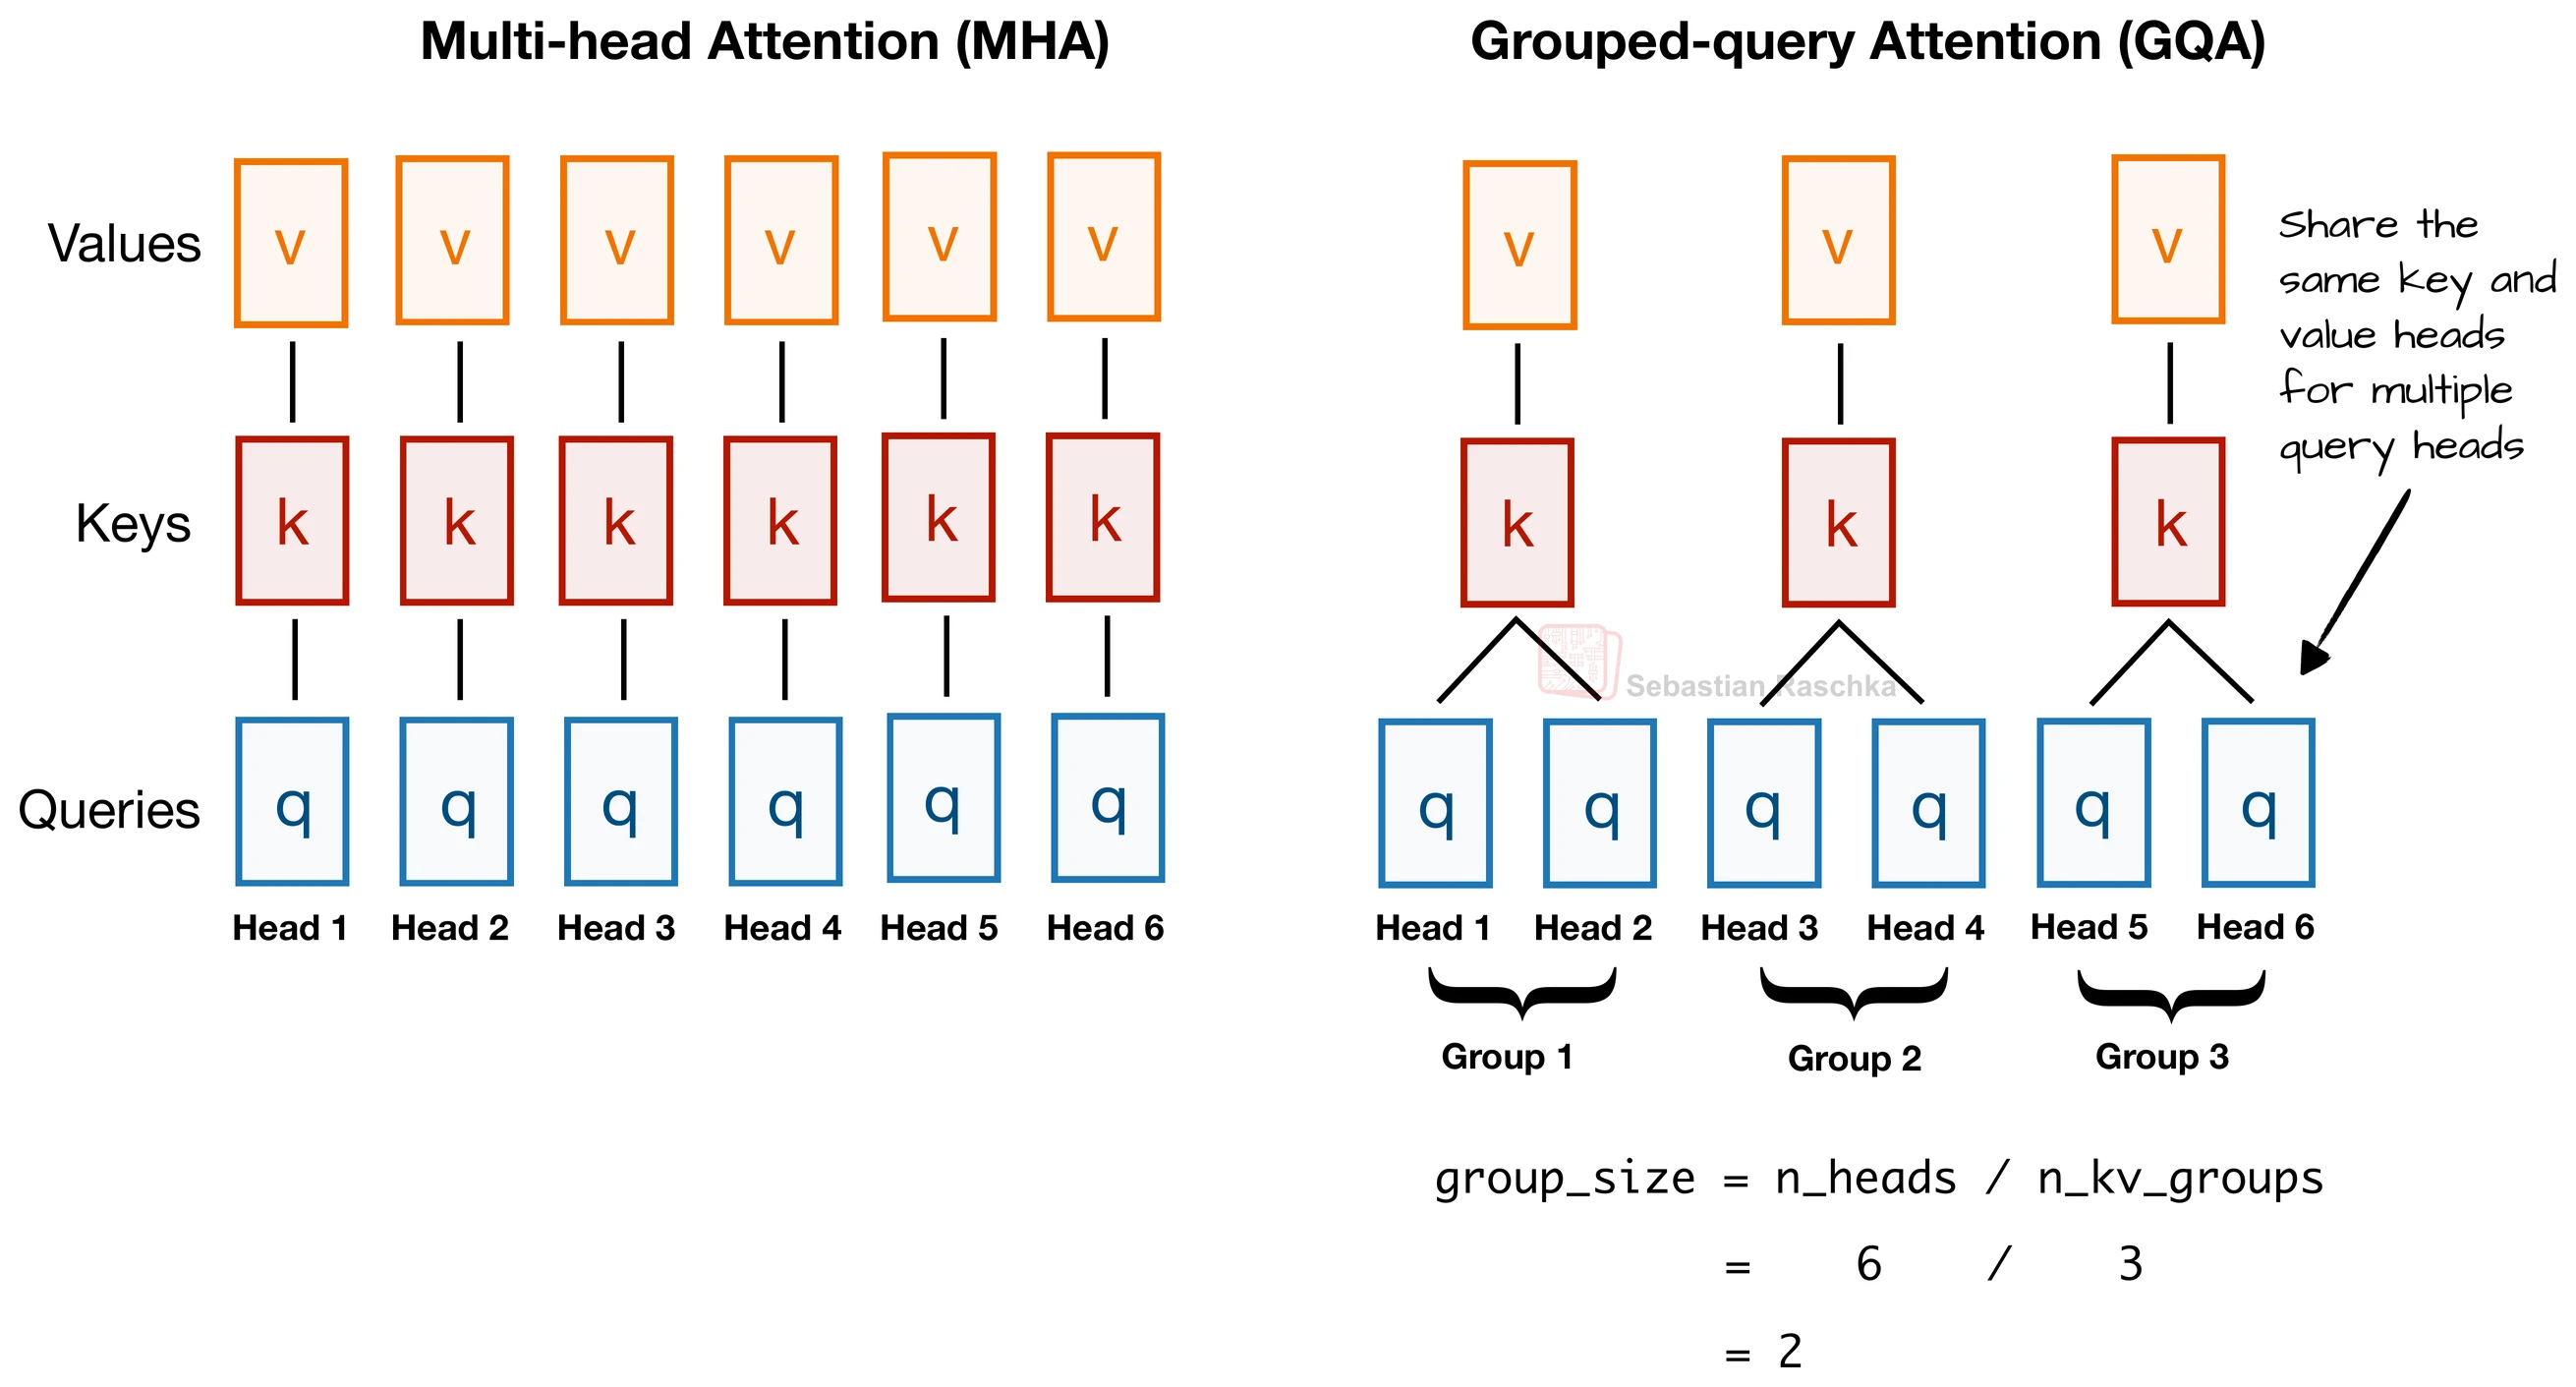

Grouped Query Attention (GQA) is a variant of multi-head attention
that reduces memory and computational cost by sharing keys and values
across groups of query heads.

In [ ]:
class GroupedQueryAttention(nn.Module):
    """
    Grouped Query Attention (GQA)
    -----------------------------
    A memory-efficient variant of multi-head attention that groups
    several query heads to share a smaller set of key/value projections.
    """

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        num_kv_groups: int,
        context_length: int,
        dropout: float = 0.1,
        qkv_bias: bool = False,
    ):
        super().__init__()
        # Reused from the above implementation of MHA
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.num_kv_groups = num_kv_groups
        self.scale = self.head_dim ** -0.5  # normalization factor for stability

        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.k_proj = nn.Linear(embed_dim, self.head_dim * num_kv_groups, bias=qkv_bias) #multiplying with kv_groups allows us to choose number of heads for the key or value
        self.v_proj = nn.Linear(embed_dim, self.head_dim * num_kv_groups, bias=qkv_bias)

        # Output projection #Reused
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        # Dropouts #Reused
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

        # Causal Mask #Reused from above implementation (MHA)
        # Lower-triangular matrix ensures each token can attend only to itself and past tokens.
        mask = torch.tril(torch.ones(context_length, context_length))
        # store this mask tensor as part of the model’s state, but don’t treat it as a learnable parameter
        self.register_buffer("causal_mask", mask.view(1, 1, context_length, context_length)) # (batch, head, query, key)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [batch, seq_len, embed_dim]
        Returns:
            out: [batch, seq_len, embed_dim]
        """
        # TODO
        B,T,C = x.shape
        H,D = self.num_heads, self.head_dim
        groups = H // self.num_kv_groups

        q = self.q_proj(x).view(B,T,H,D) #[B,T,H,D]
        k = self.k_proj(x).view(B,T,self.num_kv_groups,D) #[B,T,kv,D]
        k = k.repeat_interleave(groups,dim=2) # [B,T,H,D] , as matrix multiplication after transpose expects, H and kv to be same
        v = self.v_proj(x).view(B,T,self.num_kv_groups,D)
        v = v.repeat_interleave(groups,dim=2)

        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)

        attention_scores = (q @ k.transpose(2,3)) * self.scale

        causal_mask = self.causal_mask[:,:,:T,:T]
        attention_scores = attention_scores.masked_fill(causal_mask == 0, float("-inf"))

        attention_probs = F.softmax(attention_scores, dim=-1) # (B, H, T, T)
        attention_probs = self.attn_dropout(attention_probs) # (B, H, T, T)

        # 5. Weighted sum of values #Reused
        x = (attention_probs @ v).transpose(1, 2)  # (B, H, T, T) @ (B, H, T, D) -> (B, H, T, D) -transpose-> (B, T, H, D)

        # 6. Merge heads and apply output projection
        x = x.contiguous().view(B, T, C) # (B, T, C)
        x= self.resid_dropout(self.out_proj(x)) # (B, T, C)

        return x


In [ ]:
# To test GQA
batch_size = 4
context_length = 8
dim = 24
num_heads = 12
num_kv_groups = 2

# Simulated token embeddings
token_embeddings = torch.randn(batch_size, context_length, dim)

gqa = GroupedQueryAttention(embed_dim=dim, num_heads=num_heads,num_kv_groups = num_kv_groups, context_length=context_length)
out = gqa(token_embeddings)

print("Context vectors shape:", out.shape)

Context vectors shape: torch.Size([4, 8, 24])


### 1.3. LLM Architecture


This stage stacks multiple decoder blocks (each containing LayerNorm,
Multi-Head Attention, and Feed-Forward sublayers) to form a GPT-2-style model.

GPT-2 uses:
- Pre-LayerNorm (normalize before attention/MLP)
- Residual connections after each sub-block
- Tied input/output embeddings for LM head

#### 1.3.1. Transformer block

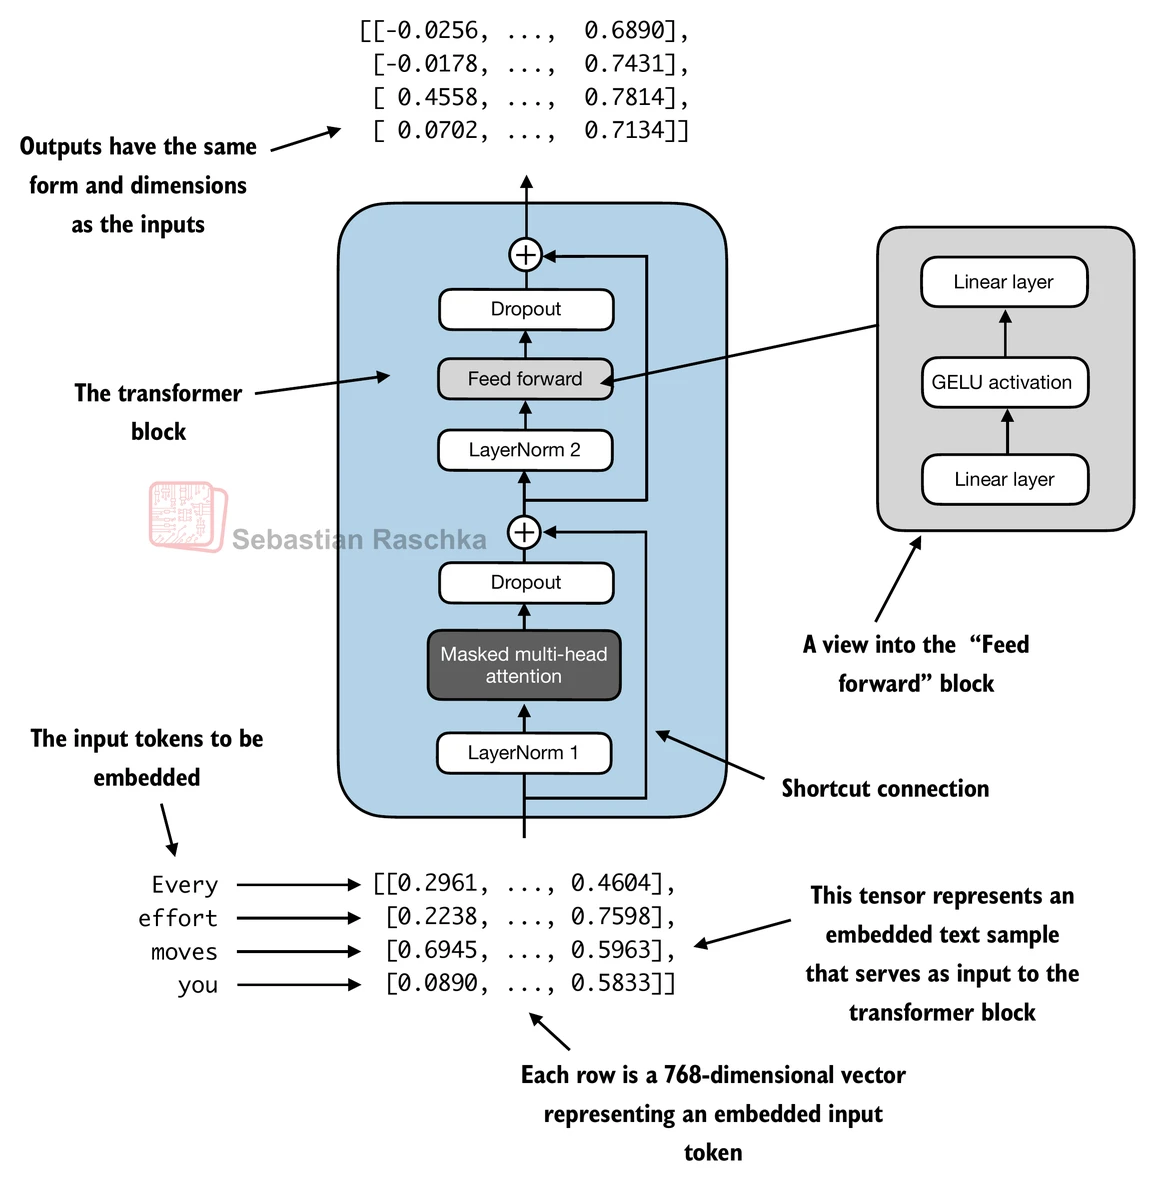

In [ ]:
class LayerNorm(nn.Module):
    """
    Custom LayerNorm used by GPT-2 (no bias on weight).
    GPT-2 applies LayerNorm before attention and MLP blocks
    (pre-norm architecture).
    """
    def __init__(self, dim: int, eps: float = 1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.bias = nn.Parameter(torch.zeros(dim))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight * norm_x + self.bias


In [ ]:
class FeedForward(nn.Module):
    """
    Two-layer MLP with GELU activation.
    Expands hidden size by 4×, then projects back.
    """
    def __init__(self, embed_dim: int, dropout: float = 0.1):
        super().__init__()
        self.c_fc = nn.Linear(embed_dim, 4 * embed_dim)
        self.act = nn.GELU()
        self.c_proj = nn.Linear(4 * embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [ ]:
class TransformerBlock(nn.Module):
    """
    One Transformer decoder block (GPT-2 style).

    Structure:
        x = x + Dropout(Attention(LayerNorm(x)))
        x = x + Dropout(FeedForward(LayerNorm(x)))
    """
    def __init__(self, cfg):
        super().__init__()
        self.ln_1 = LayerNorm(cfg["emb_dim"])
        # uncomment this block to run multi head attention
        # self.attn = MultiHeadAttention(
        #     embed_dim=cfg["emb_dim"],
        #     num_heads=cfg["n_heads"],
        #     context_length=cfg["context_length"],
        #     dropout=cfg["drop_rate"],
        #     qkv_bias=cfg["qkv_bias"],
        # )
        self.attn = GroupedQueryAttention(
            embed_dim=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            num_kv_groups = cfg["n_kv_groups"],
            context_length=cfg["context_length"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
            )
        self.ln_2 = LayerNorm(cfg["emb_dim"])
        self.mlp = FeedForward(cfg["emb_dim"], dropout=cfg["drop_rate"])

    def forward(self, x):
        # 1. Self-Attention sub-block
        attn_out = self.attn(self.ln_1(x))
        x = x + attn_out  # residual connection

        # 2. Feed-Forward sub-block
        ff_out = self.mlp(self.ln_2(x))
        x = x + ff_out   # residual connection

        return x

In [ ]:
# GPT-2 Small (124M) configuration
GPT2_SMALL_124M_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False,      # Query-Key-Value bias
    "n_kv_groups": 1
}

In [ ]:
x = torch.rand(2, 4, GPT2_SMALL_124M_CONFIG["emb_dim"])  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT2_SMALL_124M_CONFIG)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


#### 1.3.2. GPT2 Decoder

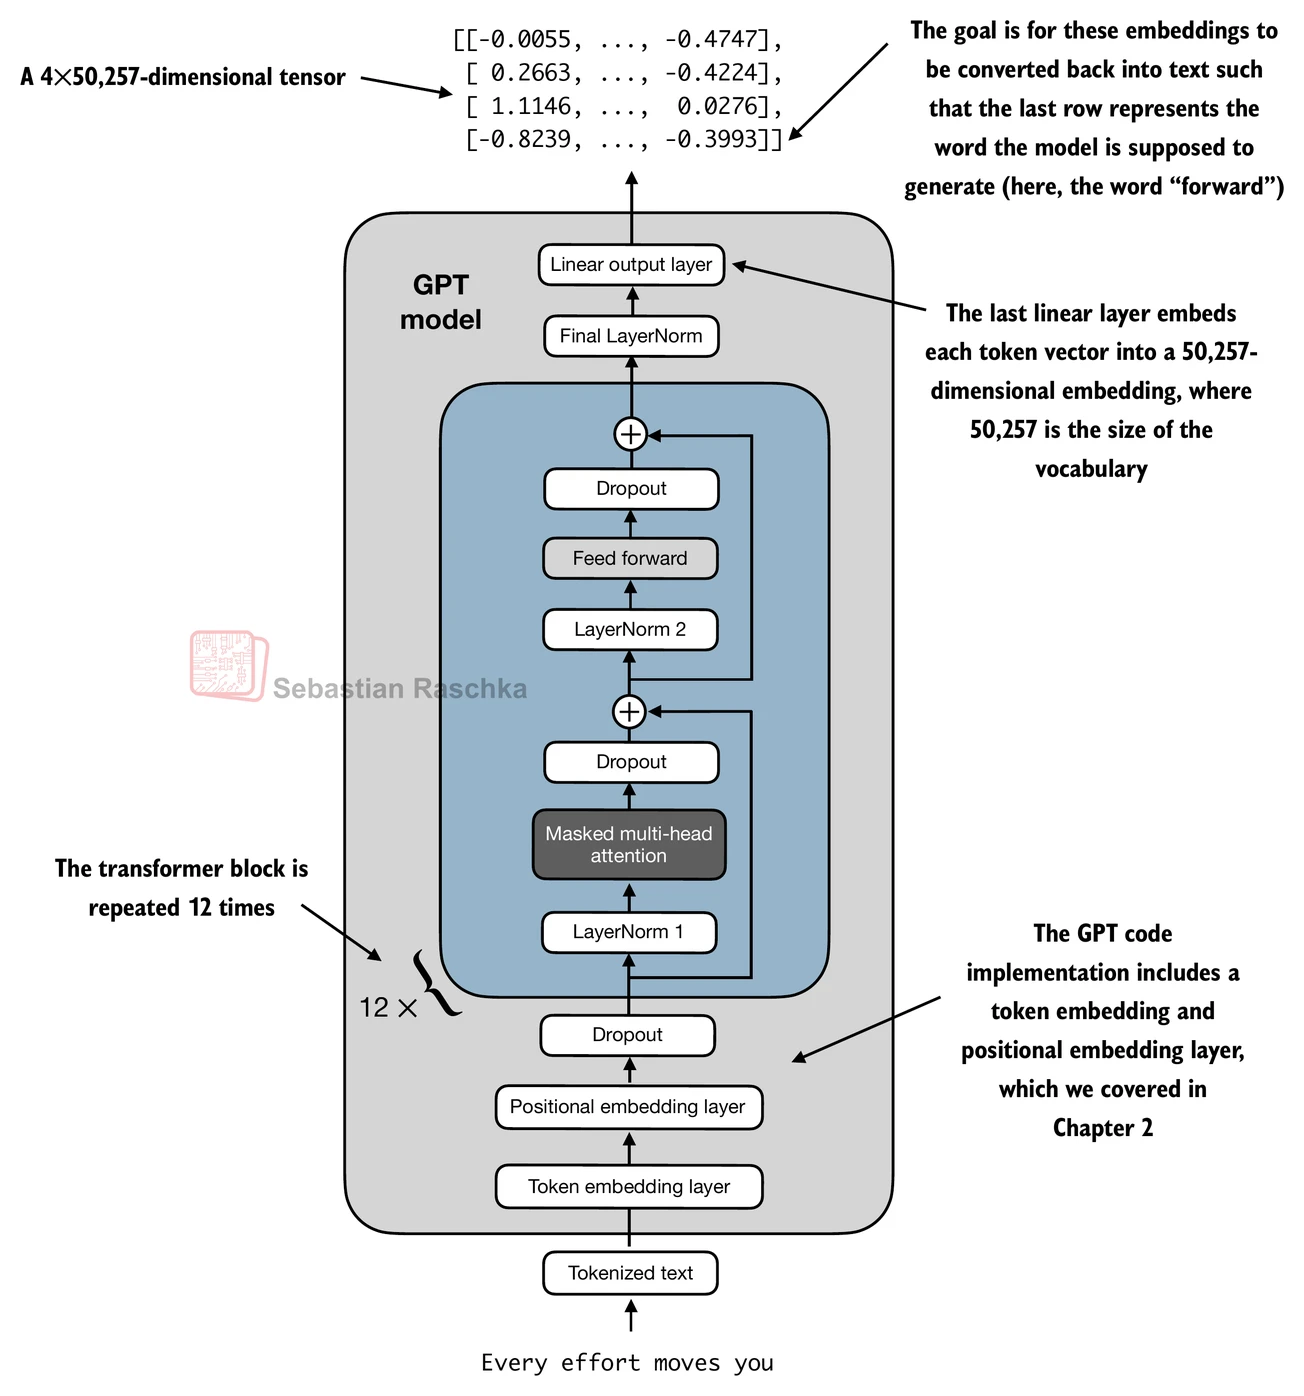

In [ ]:
class GPTModel(nn.Module):
    """
    Full GPT-2-style language model (decoder-only Transformer).

    Architecture:
        Embedding (token + position)
        N × Transformer blocks
        Final LayerNorm
        Linear head → logits over vocabulary
    """
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        vocab_size = cfg["vocab_size"]
        emb_dim = cfg["emb_dim"]
        context_length = cfg["context_length"]

        # --- Embeddings ---
        self.wte = nn.Embedding(vocab_size, emb_dim)        # token embeddings
        self.wpe = SinusoidalPositionalEncoding(emb_dim,context_length)   # position embeddings
        self.drop = nn.Dropout(cfg["drop_rate"])

        # --- Transformer blocks ---
        self.h = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # --- Final LayerNorm ---
        self.ln_f = LayerNorm(emb_dim)

        # --- LM head (tied weights with wte) ---
        self.lm_head = nn.Linear(emb_dim, vocab_size, bias=False)
        # self.lm_head.weight = self.wte.weight  # tie weights

    def forward(self, idx: torch.Tensor) -> torch.Tensor:
        """
        Args:
            idx: token IDs [batch, seq_len]
        Returns:
            logits: [batch, seq_len, vocab_size]
        """
        B, T = idx.shape
        device = idx.device

        # 1. Input embeddings
        pos = torch.arange(0, T, device=device)  # [T]
        tok_emb = self.wte(idx)                  # [B, T, C]
        pos_emb = self.wpe(tok_emb)                  # [T, C]
        x = self.drop(pos_emb)         # Add & Dropout

        # 2. Pass through transformer blocks
        for block in self.h:
            x = block(x)

        # 3. Final normalization & LM head
        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

#### 1.3.3. Number of Parameters

In [ ]:
model = GPTModel(GPT2_SMALL_124M_CONFIG)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 149,246,976


In [ ]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.lm_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 110,649,600


In [ ]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 569.33 MB


#### 1.3.4. Memory Requirement

In [ ]:
# -------------------------
# Memory tracker
# -------------------------

def print_memory_table():
    # Model parameters
    param_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    param_gb = param_bytes / 1e9

    # Gradients
    grad_bytes = sum(p.grad.numel() * p.grad.element_size() for p in model.parameters() if p.grad is not None)
    grad_gb = grad_bytes / 1e9

    # Optimizer states (AdamW: 2×)
    opt_gb = 2 * param_gb

    # Total allocated memory
    allocated_gb = torch.cuda.memory_allocated() / 1e9

    # Buffer / temporary memory (approx)
    temp_gb = allocated_gb - (param_gb + grad_gb + opt_gb) #Activations + Temporary

    print(f"{'Component':<25}{'Memory (GB)':>15}")
    print("-"*40)
    print(f"{'Model weights':<25}{param_gb:>15.3f}")
    print(f"{'Gradients':<25}{grad_gb:>15.3f}")
    print(f"{'Optimizer states':<25}{opt_gb:>15.3f}")
    print(f"{'Activations + temp':<25}{temp_gb:>15.3f}")
    print(f"{'Total allocated':<25}{allocated_gb:>15.3f}")
    print("-"*40)

torch.cuda.reset_peak_memory_stats()
print("Before training:")
print_memory_table()

Before training:
Component                    Memory (GB)
----------------------------------------
Model weights                      0.597
Gradients                          0.000
Optimizer states                   1.194
Activations + temp                -1.270
Total allocated                    0.521
----------------------------------------


## Stage 2. Foundation Model Pre-Training

This stage defines GPT2Trainer — a wrapper that handles:
- Training & validation loops
- Loss calculation (causal LM)
- Evaluation (perplexity)
- Checkpoint save/load
- Simple greedy decoding for text generation


### 2.1. Training Loop

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time
import math
import plotly.graph_objects as go

In [ ]:
class GPT2Trainer:
    """
    Handles model training, evaluation, checkpointing, and greedy decoding.
    """
    def __init__(self, model, tokenizer, train_loader, val_loader, cfg, device=None):
        """
        Args:
            model (nn.Module): GPT-2 model
            train_loader (DataLoader): training batches
            val_loader (DataLoader): validation batches
            cfg (dict): training configuration (lr, epochs, etc.)
            device (torch.device | None): compute device
        """
        self.model = model
        self.tokenizer = tokenizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.cfg = cfg
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        # Optimizer — GPT-2 commonly uses AdamW
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=cfg.get("lr", 5e-4),
            weight_decay=cfg.get("weight_decay", 0.1),
        )

        # Next-token prediction loss
        self.loss_fn = nn.CrossEntropyLoss()

        self.train_losses = []
        self.val_losses = []
        self.train_perplexities = []
        self.val_perplexities = []

        # These are added to compute accuracy.
        self.train_accuracies = []
        self.val_accuracies = []

    def calc_loss_batch(self, x, y):
        """
        Compute next-token prediction loss for one batch.
        Args:
            x: [B, T] input token IDs
            y: [B, T] target token IDs (shifted by +1)
        """
        logits = self.model(x)                   # [B, T, vocab]
        B, T, V = logits.shape
        loss = self.loss_fn(logits.view(B * T, V), y.view(B * T))
        return loss

    def calc_accuracy_batch(self,x,y):
        """
        Compute Accuracy for a single batch

        """
        logits = self.model(x)
        prediction = torch.argmax(logits,dim=-1)
        correct = (prediction == y).float().sum()
        return (correct/torch.numel(y))


    def evaluate(self, loader):
        """
        Evaluate on validation set; return mean loss.
        """
        self.model.eval()
        losses = []
        accuracies = []
        with torch.no_grad():
            for i, (x, y) in enumerate(loader):
                x, y = x.to(self.device), y.to(self.device)
                loss = self.calc_loss_batch(x, y)
                accuracy = self.calc_accuracy_batch(x,y)
                losses.append(loss.item())
                accuracies.append(accuracy.item())
        self.model.train()
        mean_loss = sum(losses) / len(losses)
        mean_accuracy = sum(accuracies) / len(accuracies)
        return mean_loss,mean_accuracy

    def train(self):
        """
        Train model across epochs and evaluate after each epoch.
        """
        num_epochs = self.cfg.get("num_epochs", 10)
        eval_prompt = self.cfg.get("start_context", "Children were playing at the")
        eval_tokens = self.cfg.get("eval_tokens", 20)

        print(f"Training on {self.device} for {num_epochs} epochs")
        start = time.time()

        for epoch in range(num_epochs):
            for step, (x, y) in enumerate(self.train_loader):
                x, y = x.to(self.device), y.to(self.device)
                loss = self.calc_loss_batch(x, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # Validation once per epoch
            train_loss,train_accuracy = self.evaluate(self.train_loader)
            train_perplexity = math.exp(train_loss)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            self.train_perplexities.append(train_perplexity)
            print(f"Epoch {epoch+1} | Train Loss {train_loss:.4f} | Perplexity {train_perplexity:.2f} | Accuracy {train_accuracy:.4f}")

            val_loss, val_accuracy = self.evaluate(self.val_loader)
            val_perplexity = math.exp(val_loss)

            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)
            self.val_perplexities.append(val_perplexity)
            print(f"Epoch {epoch+1} | Val Loss {val_loss:.4f} | Perplexity {val_perplexity:.2f} | Accuracy {val_accuracy:.4f}")

            # Generate a short sample using greedy decoding
            print("\n--- Sample Generation ---")
            # sample, duration = self.generate_greedy(eval_prompt, max_new_tokens=eval_tokens)
            sample, duration = self.generate_p_sampling(eval_prompt, 0.9, eval_tokens)
            print(f"Prompt: {eval_prompt}")
            print(f"Generated: {sample}")
            print(f"Inference time: {duration} s \n")

        print(f"Training finished in {(time.time()-start)/60:.2f} minutes.")

    def save_checkpoint(self, path="gpt2_checkpoint.pth"):
        torch.save({
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
        }, path)
        print(f"Checkpoint saved → {path}")

    def load_checkpoint(self, path="gpt2_checkpoint.pth"):
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print(f"Checkpoint loaded ← {path}")

    def generate_greedy(self, prompt: str, max_new_tokens: int = 50):
        """
        Greedy decoding — always pick the most probable next token.

        Args:
            tokenizer: BPETokenizer
            prompt (str): seed text
            max_new_tokens (int): how many tokens to generate
        """
        start = time.time()
        self.model.eval()
        tokens = torch.tensor([self.tokenizer.encode(prompt)], dtype=torch.long).to(self.device)

        for _ in range(max_new_tokens):
            # Forward pass for current sequence
            logits = self.model(tokens)          # [1, seq_len, vocab]
            next_token_logits = logits[:, -1, :] # last position only
            # Apply softmax to get probabilities
            probas = torch.softmax(next_token_logits, dim=-1)
            # Greedy: pick highest-probability token
            next_token = torch.argmax(probas, dim=-1, keepdim=True)
            # Append to running sequence
            tokens = torch.cat([tokens, next_token], dim=1)

        output_text = self.tokenizer.decode(tokens[0].tolist())
        duration = time.time() - start
        return output_text, duration


    def generate_p_sampling(self, prompt: str, p: float =0.8, max_new_tokens: int = 50):
        """
        P-sampling - add tokens until the sum of token probability is > p

        Args:
        prompt (str): text
        p: probability buffer/cutoff
        max_new_tokens (int): max tokens to generate
        """

        start = time.time()
        self.model.eval()
        tokens = torch.tensor([self.tokenizer.encode(prompt)], dtype=torch.long).to(self.device)

        for _ in range(max_new_tokens):
          # Reused from above
          # Forward pass for current sequence
          logits = self.model(tokens)          # [1, seq_len, vocab]
          next_token_logits = logits[:, -1, :] # last position only
          # Apply softmax to get probabilities
          probas = torch.softmax(next_token_logits, dim=-1)
          probas = probas.squeeze(0)           # [vocab]

          # We sort the probabilities in descending order
          sorted_probas,sorted_index = torch.sort(probas,descending = True)

          sum = 0.0
          mask = 0

          for i,prob in enumerate(sorted_probas):
            sum +=prob.item()
            if sum >= p:
              mask =i
              break


          final_probas = sorted_probas[:mask+1].tolist()
          final_index = sorted_index[:mask+1].tolist()

          next_token = random.choices(final_index,weights= final_probas,k=1)[0]

          token_tensor = torch.tensor([[next_token]], device=self.device) #converting to tensor
          tokens = torch.cat([tokens, token_tensor], dim=1)

        output_text = self.tokenizer.decode(tokens[0].tolist())
        duration = time.time() - start
        return output_text, duration


    def plot_training_curves(self):
        """
        Plots training & validation loss + perplexity using Plotly.
        """
        epochs = list(range(1, len(trainer.val_losses) + 1))
        fig = go.Figure()

        # --- Training & Validation loss ---
        fig.add_trace(go.Scatter(
            x=epochs,
            y=self.train_losses,
            mode="lines",
            name="Training Loss",
            line=dict(color="royalblue", width=2)
        ))

        fig.add_trace(go.Scatter(
            x=epochs,
            y=self.val_losses,
            mode="lines+markers",
            name="Validation Loss",
            line=dict(color="firebrick", width=2, dash="dash")
        ))

        # --- Training & Validation Perplexity ---
        fig.add_trace(go.Scatter(
            x=epochs,
            y=self.train_perplexities,
            mode="lines+markers",
            name="Training Perplexity",
            line=dict(color="darkorange", width=2)
        ))

        fig.add_trace(go.Scatter(
            x=epochs,
            y=self.val_perplexities,
            mode="lines+markers",
            name="Validation Perplexity",
            line=dict(color="green", width=2, dash="dot")
        ))

        # --- Training & Validation accuracy ---
        fig.add_trace(go.Scatter(
            x=epochs,
            y=self.train_accuracies,
            mode="lines",
            name="Training Accuracy",
            line=dict(color="royalblue", width=2)
        ))

        fig.add_trace(go.Scatter(
            x=epochs,
            y=self.val_accuracies,
            mode="lines+markers",
            name="Validation Accuracy",
            line=dict(color="firebrick", width=2, dash="dash")
        ))

        fig.update_layout(
            title="GPT-2 Training Progress",
            xaxis=dict(title="Epoch"),
            yaxis=dict(title="Loss/Perplexity/Accuracy"),
            template="plotly_white",
        )

        fig.show()

In [ ]:
tokenizer = BPETokenizer()
tokenizer.load_vocab_and_merges(vocab_path="bpe_vocab.json", merges_path="bpe_merges.json")
print("Vocabulary size:", len(tokenizer.vocab))

Vocabulary size: 50257


In [ ]:
# Train/validation ratio
train_ratio = 0.8
subset_size = 100
split_idx = int(train_ratio * subset_size)

train_data = "".join(subset["text"][:split_idx])
val_data = "".join(subset["text"][split_idx:])

In [ ]:
# GPT-2 Small (124M) configuration
GPT2_SMALL_124M_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False,      # Query-Key-Value bias
    "n_kv_groups": 1
}


In [ ]:
train_dataset = TextDataset(train_data, tokenizer,
                      block_size=GPT2_SMALL_124M_CONFIG["context_length"],
                      stride=GPT2_SMALL_124M_CONFIG["context_length"])
val_dataset = TextDataset(val_data, tokenizer,
                      block_size=GPT2_SMALL_124M_CONFIG["context_length"],
                      stride=GPT2_SMALL_124M_CONFIG["context_length"])

print("\nNum training samples:", len(train_dataset))
print("Num validation samples:", len(val_dataset))

batch_size = 4
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
)

Building dataset: 100%|██████████| 36/36 [00:00<00:00, 3173.76it/s]


Num training samples: 150
Num validation samples: 36


In [ ]:
train_cfg = {
    "lr": 5e-4,
    "num_epochs": 10,
    "weight_decay": 0.1,
    "start_context": "Children were playing at the",   # prompt to show during training
    "eval_tokens": 15                        # number of tokens to generate each epoch
}

model = GPTModel(GPT2_SMALL_124M_CONFIG)
trainer = GPT2Trainer(model, tokenizer, train_loader, val_loader, train_cfg)
trainer.train()

Training on cuda for 10 epochs
Epoch 1 | Train Loss 4.8424 | Perplexity 126.77 | Accuracy 0.2247
Epoch 1 | Val Loss 4.8743 | Perplexity 130.89 | Accuracy 0.2327

--- Sample Generation ---
Prompt: Children were playing at the
Generated: Children were playing at the, or ifsi's no det on that
Inference time: 1.446523666381836 s 

Epoch 2 | Train Loss 4.3157 | Perplexity 74.87 | Accuracy 0.2611
Epoch 2 | Val Loss 4.3959 | Perplexity 81.12 | Accuracy 0.2620

--- Sample Generation ---
Prompt: Children were playing at the
Generated: Children were playing at the forure to or whilder physicalct
Inference time: 1.6207919120788574 s 

Epoch 3 | Train Loss 3.7925 | Perplexity 44.37 | Accuracy 0.3012
Epoch 3 | Val Loss 4.0210 | Perplexity 55.76 | Accuracy 0.2941

--- Sample Generation ---
Prompt: Children were playing at the
Generated: Children were playing at the s pods loing ~ unders 
Inference time: 1.9477248191833496 s 

Epoch 4 | Train Loss 3.5315 | Perplexity 34.18 | Accuracy 0.3089
Epoch 4 |

In [ ]:
# After training
print_memory_table()
print(f"\nPeak memory during epoch: {torch.cuda.memory_allocated()/1e9:.3f} GB")
print(f"\nMemory reserved by GPU (both allocated and cached): {torch.cuda.memory_reserved()/1e9:.3f} GB")

Component                    Memory (GB)
----------------------------------------
Model weights                      0.597
Gradients                          0.597
Optimizer states                   1.194
Activations + temp                 0.636
Total allocated                    3.024
----------------------------------------

Peak memory during epoch: 3.024 GB

Memory reserved by GPU (both allocated and cached): 14.898 GB


### 2.2. Model Evaluation

####2.2.1 Quantitative Evaluation

In [ ]:
# Greedy generation after training
prompt = train_cfg["start_context"]
generated, latency = trainer.generate_greedy(prompt, max_new_tokens=15)
print("Final Generated Text:\n", generated)
print("Inference time:\n", latency, "s")

Final Generated Text:
 Children were playing at the and and and and and and and 
Inference time:
 0.23429536819458008 s


In [ ]:
# P-sampling generation after training
prompt = train_cfg["start_context"]
generated, latency = trainer.generate_p_sampling(prompt, 0.9,max_new_tokens=15)
print("Final Generated Text:\n", generated)
print("Inference time:\n", latency, "s")

Final Generated Text:
 Children were playing at the solare. in the ficine enoutora
Inference time:
 1.577491044998169 s


In [ ]:
trainer.plot_training_curves()

####2.2.2 Qualitative Evaluation

In [ ]:
# Randomly generating 5 samples from the dataset provided to us.
sample_indices = random.sample(range(len(subset)), 5)

# Get the 5 complete samples
comp_samples = [subset[i]["text"] for i in sample_indices]

# Truncate them to only 60 words
samples = [" ".join(sample.split()[:60]) for sample in comp_samples]

# Printing them
for i, sample in enumerate(samples):
    print(f"\nSample {i+1}:\n{sample}")


Sample 1:
Discover the cosmos! Each day a different image or photograph of our fascinating universe is featured, along with a brief explanation written by a professional astronomer. 2012 June 23 Explanation: As seen from Frösön island in northern Sweden the Sun did set a day after the summer solstice. From that location below the arctic circle it settled slowly behind the

Sample 2:
This is the second book wrote by Lee Lehman and presents in a very detailed manner the astrological dignities. It was published in 1989 by Whitford Press. In Chapter 1 - Two Unsung Revolutions in Astrology the author explains how the Copernican Revolution changed the way astrologers understand dignities. At page 18 one can find a table with traditional and

Sample 3:
Dengue Fever in India 04 March 2013 Dengue fever is a growing concern in India. In 2012, 247 deaths were recorded as a result of dengue fever nationwide. Latest data on disease prevalence released by the Health Ministry shows a significant ris

In [ ]:
# Testing our model on the 5 randomly generated sample.
# Using first 10 words as the prefix length, which is then passed into our model.

for i, sample in enumerate(samples):
  prefix = " ".join(sample.split()[:10])

  generated, latency = trainer.generate_greedy(prefix, max_new_tokens=60)

  print(f"\nSample {i+1}")
  print("Prefix:\n", prefix)
  print("Ground-truth:\n", sample)
  print("Model prediction:\n", generated)
  print("Inference time:", latency, "s")




Sample 1
Prefix:
 Discover the cosmos! Each day a different image or photograph
Ground-truth:
 Discover the cosmos! Each day a different image or photograph of our fascinating universe is featured, along with a brief explanation written by a professional astronomer. 2012 June 23 Explanation: As seen from Frösön island in northern Sweden the Sun did set a day after the summer solstice. From that location below the arctic circle it settled slowly behind the
Model prediction:
 Discover the cosmos! Each day a different image or photographical st and and and and and and and and and and and and and and and and and and and and and and and and and and and and 
Inference time: 0.9803597927093506 s

Sample 2
Prefix:
 This is the second book wrote by Lee Lehman and
Ground-truth:
 This is the second book wrote by Lee Lehman and presents in a very detailed manner the astrological dignities. It was published in 1989 by Whitford Press. In Chapter 1 - Two Unsung Revolutions in Astrology the author ex

In [ ]:
# Testing our model on the 5 randomly generated sample.Using p-sampling method here
# Using first 10 words as the prefix length, which is then passed into our model.

for i, sample in enumerate(samples):
  prefix = " ".join(sample.split()[:10])

  generated, latency = trainer.generate_p_sampling(prefix, 0.9,max_new_tokens=60)

  print(f"\nSample {i+1}")
  print("Prefix:\n", prefix)
  print("Ground-truth:\n", sample)
  print("Model prediction:\n", generated)
  print("Inference time:", latency, "s")


Sample 1
Prefix:
 Discover the cosmos! Each day a different image or photograph
Ground-truth:
 Discover the cosmos! Each day a different image or photograph of our fascinating universe is featured, along with a brief explanation written by a professional astronomer. 2012 June 23 Explanation: As seen from Frösön island in northern Sweden the Sun did set a day after the summer solstice. From that location below the arctic circle it settled slowly behind the
Model prediction:
 Discover the cosmos! Each day a different image or photograph unfourcests effectively alence (S (e.g. the forntical Stly and Arizon applies with their werna. 
 be of the wellotec
Inference time: 5.755384683609009 s

Sample 2
Prefix:
 This is the second book wrote by Lee Lehman and
Ground-truth:
 This is the second book wrote by Lee Lehman and presents in a very detailed manner the astrological dignities. It was published in 1989 by Whitford Press. In Chapter 1 - Two Unsung Revolutions in Astrology the author explai

### 2.3. Save and Load the Model

In [ ]:
# Save
trainer.save_checkpoint()

Checkpoint saved → gpt2_checkpoint.pth


In [ ]:
# trainer.load_checkpoint()

In [ ]:
print(trainer.model)

GPTModel(
  (wte): Embedding(50257, 768)
  (wpe): SinusoidalPositionalEncoding()
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln_1): LayerNorm()
      (attn): GroupedQueryAttention(
        (q_proj): Linear(in_features=768, out_features=768, bias=False)
        (k_proj): Linear(in_features=768, out_features=64, bias=False)
        (v_proj): Linear(in_features=768, out_features=64, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm()
      (mlp): FeedForward(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm()
  (lm_head): Linear(in_features=768

## Stage 3. Fine-tuning

Now, let's try to do some supervised fine-tuning for Sentiment analysis using GPT2.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("gpt2_checkpoint.pth", map_location=device)
model = GPTModel(GPT2_SMALL_124M_CONFIG)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [ ]:
model

GPTModel(
  (wte): Embedding(50257, 768)
  (wpe): SinusoidalPositionalEncoding()
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln_1): LayerNorm()
      (attn): GroupedQueryAttention(
        (q_proj): Linear(in_features=768, out_features=768, bias=False)
        (k_proj): Linear(in_features=768, out_features=64, bias=False)
        (v_proj): Linear(in_features=768, out_features=64, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm()
      (mlp): FeedForward(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm()
  (lm_head): Linear(in_features=768

### 3.1. Dataset Preparation

In [ ]:
from torch.utils.data import Dataset

class FineTuneDataset(Dataset):
    """
    Tokenizes each sentence, pads/truncates to max_length,
    and pairs with its label (if classification) or uses next-token prediction.
    """

    def __init__(self, data, tokenizer, max_length=None, pad_token_id=398):
        """
        Args:
            data (Dataset | DataFrame): text + label columns
            tokenizer (BPETokenizer)
            max_length (int): fixed sequence length
            pad_token_id (int): padding ID
        """
        self.data = data.to_pandas()

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["sentence"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [ ]:
# get special token id
tokenizer.inverse_vocab["<|endoftext|>"]

398

In [ ]:
from datasets import load_dataset
from torch.utils.data import DataLoader

# Load Stanford Sentiment Treebank v2
dataset = load_dataset("stanfordnlp/sst2")

# Split train/val/test
data = dataset["train"].train_test_split(train_size=1000, test_size=100, stratify_by_column="label")
train_data = data["train"]
val_data = data["test"]

# Tokenize
train_ds = FineTuneDataset(train_data, tokenizer, max_length=None, pad_token_id=398)
max_length = train_ds.max_length
print("Max length in the training data:", train_ds.max_length)

val_ds = FineTuneDataset(val_data, tokenizer, max_length=None, pad_token_id=398)
print("Max length in the validation data:", val_ds.max_length)

print("Training data size:", len(train_ds))
print("Validation data size:", len(val_ds))

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Max length in the training data: 128
Max length in the validation data: 111
Training data size: 1000
Validation data size: 100


In [ ]:
batch_size = 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)

NameError: name 'train_ds' is not defined

### 3.2. Training

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.h[-1].parameters():
    param.requires_grad = True

for param in model.ln_f.parameters():
    param.requires_grad = True

Technically, it's sufficient to only train the output layer; however, experiments show that finetuning additional layers can noticeably improve the performance. So, we are also making the last transformer block and the final LayerNorm module connecting the last transformer block to the output layer trainable.

In [ ]:
# Ignore this if using summarization fine tuning
num_classes = 2
model.lm_head = torch.nn.Linear(in_features=GPT2_SMALL_124M_CONFIG["emb_dim"], out_features=num_classes)
model.lm_head.to(device)

Linear(in_features=768, out_features=2, bias=True)

In [ ]:
model

GPTModel(
  (wte): Embedding(50257, 768)
  (wpe): SinusoidalPositionalEncoding()
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln_1): LayerNorm()
      (attn): GroupedQueryAttention(
        (q_proj): Linear(in_features=768, out_features=768, bias=False)
        (k_proj): Linear(in_features=768, out_features=64, bias=False)
        (v_proj): Linear(in_features=768, out_features=64, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm()
      (mlp): FeedForward(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm()
  (lm_head): Linear(in_features=768

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
import math
import time

class GPT2FineTuner():
    """
    Fine-tuning GPT-2 for classification.
    Tracks loss and accuracy during training and validation.
    """

    def __init__(self, model, tokenizer, train_loader, val_loader, cfg, device=None):
        self.model = model
        self.tokenizer = tokenizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.cfg = cfg
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        # Optimizer — GPT-2 commonly uses AdamW
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=cfg.get("lr", 5e-4),
            weight_decay=cfg.get("weight_decay", 0.1),
        )

        self.loss_fn = nn.CrossEntropyLoss()

        # Initialize tracking
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def calc_accuracy(self, logits, y):
        preds = torch.argmax(logits, dim=1)
        correct = (preds == y).sum().item()
        total = y.size(0)
        return correct / total

    def calc_loss_batch(self, x, y):
        logits = self.model(x)             # [B, num_tokens, num_classes]
        last_logits = logits[:, -1, :]      # Logits of last output token → [B, num_classes]
        loss = self.loss_fn(last_logits, y)
        acc = self.calc_accuracy(last_logits, y)
        return loss, acc

    def train(self):
        num_epochs = self.cfg.get("num_epochs", 5)

        print(f"Fine-tuning on {self.device} for {num_epochs} epochs")
        start = time.time()

        for epoch in range(num_epochs):
            self.model.train()
            train_losses, train_accs = [], []

            for step, (x, y) in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                x, y = x.to(self.device), y.to(self.device)
                loss, acc = self.calc_loss_batch(x, y)
                loss.backward()
                self.optimizer.step()

            # Compute training metrics
            train_loss, train_acc = self.evaluate(self.train_loader)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f} | Train Accuracy {train_acc*100:.2f}%")

            # Validation
            val_loss, val_acc = self.evaluate(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f"Epoch {epoch+1}: Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

        print(f"Fine-tuning complete in {(time.time()-start)/60:.2f} minutes.")

    def evaluate(self, loader):
        self.model.eval()
        losses, accs = [], []
        with torch.no_grad():
            for i, (x, y) in enumerate(loader):
                x, y = x.to(self.device), y.to(self.device)
                logits = self.model(x)
                last_logits = logits[:, -1, :]
                loss = self.loss_fn(last_logits, y)
                acc = self.calc_accuracy(last_logits, y)
                losses.append(loss.item())
                accs.append(acc)
        self.model.train()
        return sum(losses) / len(losses), sum(accs) / len(accs)

    def plot_finetune_curves(self):
        epochs = list(range(1, len(self.train_losses) + 1))
        fig = go.Figure()

        # Loss curves
        fig.add_trace(go.Scatter(
            x=epochs, y=self.train_losses,
            mode="lines+markers", name="Train Loss",
            line=dict(color="royalblue", width=2)
        ))
        fig.add_trace(go.Scatter(
            x=epochs, y=self.val_losses,
            mode="lines+markers", name="Validation Loss",
            line=dict(color="firebrick", width=2, dash="dash")
        ))

        fig.add_trace(go.Scatter(
            x=epochs, y=[a*100 for a in self.train_accuracies],
            mode="lines+markers", name="Train Accuracy (%)",
            line=dict(color="darkorange", width=2)
        ))
        fig.add_trace(go.Scatter(
            x=epochs, y=[a*100 for a in self.val_accuracies],
            mode="lines+markers", name="Validation Accuracy (%)",
            line=dict(color="green", width=2, dash="dot")
        ))

        fig.update_layout(
            title="GPT-2 Fine-Tuning — Loss and Accuracy",
            xaxis=dict(title="Epoch"),
            yaxis=dict(title="Loss/Accuracy"),
            template="plotly_white",
        )

        fig.show()

In [ ]:
finetune_cfg = {
    "lr": 1e-4,
    "num_epochs": 5,
    "weight_decay": 0.01,
}

finetuner = GPT2FineTuner(model, tokenizer, train_loader, val_loader, finetune_cfg)

In [ ]:
finetuner.train()

Fine-tuning on cuda for 5 epochs
Epoch 1: Train Loss 0.6415 | Train Accuracy 62.60%
Epoch 1: Val Loss: 0.6468 | Val Acc: 62.00%
Epoch 2: Train Loss 0.6298 | Train Accuracy 62.30%
Epoch 2: Val Loss: 0.7244 | Val Acc: 57.00%
Epoch 3: Train Loss 0.5169 | Train Accuracy 78.50%
Epoch 3: Val Loss: 0.6586 | Val Acc: 61.00%
Epoch 4: Train Loss 0.4427 | Train Accuracy 80.40%
Epoch 4: Val Loss: 0.7054 | Val Acc: 63.00%
Epoch 5: Train Loss 0.3830 | Train Accuracy 84.40%
Epoch 5: Val Loss: 0.7283 | Val Acc: 59.00%
Fine-tuning complete in 1.61 minutes.


In [ ]:
# Plot interactive metrics
finetuner.plot_finetune_curves()

### 3.3. Inference

In [ ]:
import torch

def classify_review(
    text,
    model,
    tokenizer,
    device,
    max_length: int = None,
    pad_token_id: int = 398
):
    """
    Classify a text review (e.g., positive/negative) using a fine-tuned GPT-2 model.

    Args:
        text (str): Input review text
        model (nn.Module): Fine-tuned GPT-2 model with classification head
        tokenizer (BPETokenizer): Tokenizer used during training
        device (torch.device): 'cuda' or 'cpu'
        max_length (int): Context length (must be ≤ model context)
        pad_token_id (int): Token ID for padding
    Returns:
        str: "Positive" or "Negative"
    """
    model.eval()

    # 1. Encode text to token IDs
    input_ids = tokenizer.encode(text)
    supported_context_length = model.wpe.num_embeddings  # GPT-2 positional embedding length

    # 2. Ensure max_length is valid
    if max_length is None:
        max_length = supported_context_length
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) exceeds model's supported context length "
        f"({supported_context_length})."
    )

    # 3. Truncate or pad
    input_ids = input_ids[:max_length]
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)  # [1, T]

    # 4. Forward pass
    with torch.no_grad():
        logits = model(input_tensor)
        # If model outputs [B, T, num_classes], take final token only
        if logits.dim() == 3:
            logits = logits[:, -1, :]  # [1, num_classes]

    # 5. Predicted label
    pred = torch.argmax(logits, dim=-1).item()
    return "Positive" if pred == 1 else "Negative"


In [ ]:
sample_texts = [
    "I absolutely loved this movie. The performances were great!",
    "Boring!",
    "Very bad!",
    "Pathetic! Waste of time!"
]

for review in sample_texts:
    label = classify_review(
        review,
        model,
        tokenizer,
        device,
        max_length=64
    )
    print(f"{review} → {label}")


I absolutely loved this movie. The performances were great! → Positive
Boring! → Negative
Very bad! → Negative
Pathetic! Waste of time! → Positive


## 3.4 Preparing Summarization Dataset

In [ ]:
# Re used
for param in model.parameters():
    param.requires_grad = False

for param in model.h[-1].parameters():
    param.requires_grad = True

for param in model.ln_f.parameters():
    param.requires_grad = True

In [ ]:
model

GPTModel(
  (wte): Embedding(50257, 768)
  (wpe): SinusoidalPositionalEncoding()
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln_1): LayerNorm()
      (attn): GroupedQueryAttention(
        (q_proj): Linear(in_features=768, out_features=768, bias=False)
        (k_proj): Linear(in_features=768, out_features=64, bias=False)
        (v_proj): Linear(in_features=768, out_features=64, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm()
      (mlp): FeedForward(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm()
  (lm_head): Linear(in_features=768

In [ ]:
import re

class SummarizationDataset(Dataset):
  def __init__(self, data, tokenizer, max_length=None, pad_token_id=398):
        self.data = data.to_pandas()
        self.pad_token_id = pad_token_id
        self.tokenizer = tokenizer

        self.encoded_texts = []

        for _, row in self.data.iterrows():
            instruction = row["instruction"]
            summary = row["response"]

            # Building a causal LM training example
            text = f"Summarize:\n{instruction}\n\nSummary:\n{summary}"

            text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()\-\s]", "", text) # Remove unknown characters

            ids = tokenizer.encode(text)
            self.encoded_texts.append(ids)


        if max_length is None: # Determine max length
            self.max_length = max(len(x) for x in self.encoded_texts)
        else:
            self.max_length = max_length
            self.encoded_texts = [x[:self.max_length] for x in self.encoded_texts]


        self.input_ids = [
            x + [pad_token_id] * (self.max_length - len(x)) # Pad sequences
            for x in self.encoded_texts
        ]


        self.labels = [
            [(i if i != pad_token_id else -100) for i in seq] # Labels = pad tokens(-100)
            for seq in self.input_ids
        ]

  def __len__(self):
      return len(self.input_ids)

  def __getitem__(self, index):
      return (
          torch.tensor(self.input_ids[index], dtype=torch.long),
          torch.tensor(self.labels[index], dtype=torch.long)
      )

In [ ]:
from datasets import load_dataset
from torch.utils.data import DataLoader

# Load Databricks Dolly-15k dataset
dataset = load_dataset("databricks/databricks-dolly-15k")
dataset = dataset["train"].filter(lambda x: x["category"] == "summarization")

# Splitting train/val/test in 80/10/10 ratio

split = dataset.train_test_split(test_size=0.2)
train_data = split["train"]
remaining = split["test"]

split_1 = remaining.train_test_split(test_size=0.5)
val_data = split_1["train"]
test_data = split_1["test"]

# Tokenize

train_ds = SummarizationDataset(train_data, tokenizer, max_length=1024, pad_token_id=398)
max_length = train_ds.max_length
print("Max length in the training data:", train_ds.max_length)

val_ds = SummarizationDataset(val_data, tokenizer, max_length=1024, pad_token_id=398)
print("Max length in the validation data:", val_ds.max_length)

test_ds = SummarizationDataset(test_data, tokenizer, max_length=1024, pad_token_id=398)

print("Training data size:", len(train_ds))
print("Validation data size:", len(val_ds))


README.md: 0.00B [00:00, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15011 [00:00<?, ? examples/s]

Max length in the training data: 1024
Max length in the validation data: 1024
Training data size: 950
Validation data size: 119


In [ ]:
batch_size = 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds,batch_size=batch_size)

### 3.5 Training Pipeline

In [ ]:
!pip install evaluate
!pip install rouge_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d83b43de031f606782ac07a5ca375d5846f2eb0e5532fd23b2da19c76e2c8063
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
import math
import time
import evaluate
rouge =evaluate.load("rouge")

class GPT2FineTuner_Summ():
    """
    Fine-tuning GPT-2 for summarization.
    Tracks loss and Rouge-L during training and validation.
    """

    def __init__(self, model, tokenizer, train_loader, val_loader,test_loader, cfg, device=None):
        # Initialising
        self.model = model
        self.tokenizer = tokenizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.cfg = cfg
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        # Optimizer — GPT-2 commonly uses AdamW
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=cfg.get("lr", 5e-4),
            weight_decay=cfg.get("weight_decay", 0.1),
        )

        self.loss_fn = nn.CrossEntropyLoss(ignore_index=-100) #ignore padded tokens

        # Initialize tracking
        self.train_losses = []
        self.val_losses = []
        self.test_losses = []
        self.train_rouges = []
        self.val_rouges = []
        self.test_rouges = []

    # def calc_accuracy(self, logits, y):
    #     preds = torch.argmax(logits, dim=1)
    #     correct = (preds == y).sum().item()
    #     total = y.size(0)
    #     return correct / total

    def calc_loss_batch(self, batch):

        input_ids, labels = batch
        vocab_size = len(self.tokenizer.vocab)
        # cpu to gpu
        input_ids = input_ids.to(self.device)
        labels    = labels.to(self.device)

        logits = self.model(input_ids) # Our model only returns logits
        B,T,V = logits.shape
        loss = self.loss_fn(logits.view(B*T, V), labels.view(B*T)) # We need to manually evaluate loss based on the logits(cross entropy loss).
        return loss

    def evaluate(self, loader):
        self.model.eval()
        losses = []
        prediction = []
        ref = []
        with torch.no_grad():
            for item in loader:
                input_ids, labels = item
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)
                logits = self.model(input_ids)

                B,T,V = logits.shape
                loss = self.loss_fn(logits.view(B*T, V), labels.view(B*T))
                losses.append(loss.item())

                # calculate rouge-l
                pred_id = torch.argmax(logits,dim=-1) #[B,T,V] choose max from V so [B,T]
                for x,y in zip(pred_id,labels):
                  x = [token for token, label in zip(x.tolist(), y.tolist()) if label != -100]
                  y = [i for i in y.tolist() if i != -100] # Filtering out pad tokens from the labels
                  prediction.append(self.tokenizer.decode(x))
                  ref.append(self.tokenizer.decode(y))
        # https://medium.com/@MUmarAmanat/llm-evaluation-with-rouge-0ebf6cf2aed4 Using this soruce to calculate rouge-L
        rouge_l =0.0

        if len(prediction)>0:
          rouge_l= rouge.compute(predictions=prediction, references=ref, use_aggregator=True).get('rougeL', 0.0) #compute function returns a dictionary

        self.model.train()
        return sum(losses) / len(losses), rouge_l

    def train(self):
        num_epochs = self.cfg.get("num_epochs", 5)

        print(f"Fine-tuning on {self.device} for {num_epochs} epochs")
        start = time.time()

        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0

            for batch in self.train_loader:
                self.optimizer.zero_grad()
                loss = self.calc_loss_batch(batch)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            # Training
            train_loss, train_rouge = self.evaluate(self.train_loader)
            self.train_losses.append(train_loss)
            self.train_rouges.append(train_rouge)
            print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f} | Train Rouge {train_rouge:.4f}")

            # Validation
            val_loss, val_rouge = self.evaluate(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_rouges.append(val_rouge)

            print(f"Epoch {epoch+1}: Val Loss: {val_loss:.4f} | Val Rouge: {val_rouge:.4f}")

            # Test
            test_loss, test_rouge = self.evaluate(self.test_loader)
            self.test_losses.append(test_loss)
            self.test_rouges.append(test_rouge)

            print(f"Epoch {epoch+1}: Test Loss: {test_loss:.4f} | Test Rouge: {test_rouge:.4f}")

        print(f"Fine-tuning complete in {(time.time()-start)/60:.2f} minutes.")

    def plot_finetune_curves(self):
        epochs = list(range(1, len(self.train_losses) + 1))
        fig = go.Figure()

        # Loss curves
        fig.add_trace(go.Scatter(
            x=epochs, y=self.train_losses,
            mode="lines+markers", name="Train Loss",
            line=dict(color="royalblue", width=2)
        ))
        fig.add_trace(go.Scatter(
            x=epochs, y=self.val_losses,
            mode="lines+markers", name="Validation Loss",
            line=dict(color="firebrick", width=2, dash="dash")
        ))


        fig.add_trace(go.Scatter(
            x=epochs, y=self.test_losses,
            mode="lines+markers", name="Test Loss",
            line=dict(color="purple", width=2, dash="dash")
        ))

        fig.add_trace(go.Scatter(
            x=epochs, y=self.train_rouges,
            mode="lines+markers", name="Train Rouge-L",
            line=dict(color="darkorange", width=2)
        ))
        fig.add_trace(go.Scatter(
            x=epochs, y=self.val_rouges,
            mode="lines+markers", name="Val Rouge-L",
            line=dict(color="green", width=2, dash="dot")
        ))

        fig.add_trace(go.Scatter(
            x=epochs, y=self.test_rouges,
            mode="lines+markers", name="Test Rouge-L",
            line=dict(color="magenta", width=2, dash="dash")
        ))


        fig.update_layout(
            title="GPT-2 Fine-Tuning — Loss and Rouge-L",
            xaxis=dict(title="Epoch"),
            yaxis=dict(title="Loss/Rouge-L"),
            template="plotly_white",
        )

        fig.show()

In [ ]:
finetune_cfg = {
    "lr": 1e-4,
    "num_epochs": 5,
    "weight_decay": 0.01,
}

finetuner = GPT2FineTuner_Summ(model, tokenizer, train_loader, val_loader,test_loader ,finetune_cfg)

In [ ]:
finetuner.train()

Fine-tuning on cuda for 5 epochs
Epoch 1: Train Loss 1.5136 | Train Rouge 0.4902
Epoch 1: Val Loss: 1.5317 | Val Rouge: 0.5040
Epoch 1: Test Loss: 1.5408 | Test Rouge: 0.4980
Epoch 2: Train Loss 0.8746 | Train Rouge 0.6925
Epoch 2: Val Loss: 0.9066 | Val Rouge: 0.6904
Epoch 2: Test Loss: 0.9061 | Test Rouge: 0.6871
Epoch 3: Train Loss 0.6367 | Train Rouge 0.7689
Epoch 3: Val Loss: 0.6792 | Val Rouge: 0.7678
Epoch 3: Test Loss: 0.6728 | Test Rouge: 0.7620
Epoch 4: Train Loss 0.4969 | Train Rouge 0.8242
Epoch 4: Val Loss: 0.5425 | Val Rouge: 0.8177
Epoch 4: Test Loss: 0.5362 | Test Rouge: 0.8146
Epoch 5: Train Loss 0.3979 | Train Rouge 0.8668
Epoch 5: Val Loss: 0.4491 | Val Rouge: 0.8523
Epoch 5: Test Loss: 0.4413 | Test Rouge: 0.8561
Fine-tuning complete in 21.33 minutes.


In [ ]:
finetuner.plot_finetune_curves()

### 3.6 Inference and Qualitative Evaluation

In [ ]:
import torch

def generate_summary(
    text,
    model,
    tokenizer,
    device,
    max_length: int = 128,
    pad_token_id: int = 398
):
    """
    Generate a summary for a given instruction using a fine-tuned GPT-2 model.

    Args:
        text (str): Input text to summarize(prompt)
        model (nn.Module): Fine-tuned GPT-2 model
        tokenizer (BPETokenizer)
        device (torch.device): 'cuda' or 'cpu'
        max_length (int): Max tokens to generate
        pad_token_id (int): Padding token ID
    Returns:
        str: Generated summary
    """
    model.eval()
    model.to(device)

    prompt = f"Summarize:\n{text}\n\nSummary:\n" # Building input text
    input_ids = tokenizer.encode(prompt) # Tokenizing the input
    input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)  # [1, T]
    input_ids = input_ids[:, -model.cfg["context_length"]:] #  pos embedding has 1024
    output = input_ids.clone() #Making a copy to be later used

    for _ in range(max_length):
      with torch.no_grad():
        logits = model(output)
        next_token_logit = logits[:,-1,:] #Taking the last layer
        probs = torch.softmax(next_token_logit / 1.0, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1) # sampling one token after applying softmax

        if pad_token_id != None and next_token.item() == pad_token_id : #If the token is a padding token, we can end generating text
          break
        output = torch.cat([output, next_token], dim=-1)

    generated_ids = output[0].tolist()[input_ids.shape[1]:]
    summary = tokenizer.decode(generated_ids).strip() # strip to remove unnecesaary spaces
    return summary

In [ ]:
random_index = random.sample(range(len(test_ds)),5)

for i in random_index:
  input_ids, label =test_ds[i]
  prompt = tokenizer.decode([input for input in input_ids.tolist() if input != 398])
  true_summary = tokenizer.decode([label for label in label.tolist() if label != -100])

  generated_summary = generate_summary(prompt, finetuner.model, tokenizer, device)

  print(f"Prompt:\n{prompt}")
  print(f"Original Summary:\n\n{true_summary}")
  print(f"Generated Summary:\n\n{generated_summary}")
  print("-----------------------------")

Prompt:
Summarize: 
 What is Zenthoefer Furs 
 
 Summary: 
 Zenthoefer Furs were an amateur U.S. soccer club which played in St. Louis, Missouri during the late 1940s and early 1950s.
Original Summary:

Summarize: 
 What is Zenthoefer Furs 
 
 Summary: 
 Zenthoefer Furs were an amateur U.S. soccer club which played in St. Louis, Missouri during the late 1940s and early 1950s.
Generated Summary:


-----------------------------
Prompt:
Summarize: 
 What are the potential source of energy for an engine? 
 
 Summary: 
 Potential sources of an engine includes potential energy, heat energy chemical energy, electrical energy and nuclear energy.
Original Summary:

Summarize: 
 What are the potential source of energy for an engine? 
 
 Summary: 
 Potential sources of an engine includes potential energy, heat energy chemical energy, electrical energy and nuclear energy.
Generated Summary:


-----------------------------
Prompt:
Summarize: 
 What is Russia-Ukraine Conflict? 
 
 Summary: 
 The dec